In [ ]:
!nvidia-smi

In [ ]:
!pip install transformers
# !pip install -U adapter-transformers
!git clone https://github.com/intfloat/SimKGC.git
!git clone https://github.com/ngl567/CAKE.git

In [ ]:
!gdown 1NIqba7bn8rfrG9jIyjKgvJBdiJGoP9OG

In [ ]:
%cd /content/SimKGC
!bash scripts/preprocess.sh FB15k237

In [ ]:
# Replace args with this
'''
args = parser.parse_args(['--eval-model-path', '/content/model_best.mdl',
    '--train-path', '/content/SimKGC/data/FB15k237/train.txt.json',
    '--valid-path', '/content/SimKGC/data/FB15k237/test.txt.json',
    '--task', 'fb15k237', '--is-test'])
'''

In [ ]:
from triplet import ConceptDict, TripletDict, LinkGraph, EntityDict

concepts = ConceptDict('/content/CAKE/data_concept/FB15k-237_concept')
triplets = TripletDict(['/content/SimKGC/data/FB15k237/train.txt.json',
                        '/content/SimKGC/data/FB15k237/test.txt.json',
                        '/content/SimKGC/data/FB15k237/valid.txt.json'])
entities_dict = EntityDict('/content/SimKGC/data/FB15k237')
links = LinkGraph('/content/SimKGC/data/FB15k237/train.txt.json')

[2022-07-12 08:40:49,568 INFO] Start to build concept dictionary from /content/CAKE/data_concept/FB15k-237_concept
[2022-07-12 08:40:49,642 INFO] Triplets path: ['/content/SimKGC/data/FB15k237/train.txt.json', '/content/SimKGC/data/FB15k237/test.txt.json', '/content/SimKGC/data/FB15k237/valid.txt.json']
[2022-07-12 08:40:51,845 INFO] Triplet statistics: 474 relations, 35070 triplets
[2022-07-12 08:40:51,923 INFO] Load 14541 entities from /content/SimKGC/data/FB15k237/entities.json


In [ ]:
from predict import BertPredictor

predictor = BertPredictor()
predictor.load('/content/model_best.mdl')

In [ ]:
import json
import random

with open('/content/SimKGC/data/FB15k237/relations.json') as f:
    relations_dict = json.load(f)
relations = list(relations_dict.values())

with open('/content/SimKGC/data/FB15k237/entities.json') as f:
    entities = json.load(f)
print(entities[0])

id2ent = {ent["entity_id"]: ent["entity"] for ent in entities}

with open('/content/SimKGC/data/FB15k237/train.txt.json') as f:
    train_data = json.load(f)
    

{'entity_id': '/m/027rn', 'entity': 'Dominican Republic', 'entity_desc': '"The Dominican Republic is a nation on the island of Hispaniola, part of the Greater Antilles archipelago in the Caribbean region. The western three-eighths of the island is occupied by the nation of Haiti, making Hispaniola one of two Caribbean islands, along with Saint Martin, that are shared by two'}


In [ ]:
rel = relations[220]
print(f'Relation to use: {rel}')

sampled_data = [data_ex for data_ex in train_data if data_ex["relation"] == rel]
data_heads = [ex['head'] for ex in sampled_data]
data_head_ids = [ex['head_id'] for ex in sampled_data]
data_tails = [ex['tail'] for ex in sampled_data]
data_tail_ids = [ex['tail_id'] for ex in sampled_data]

print('Heads of the given relation:')
print(set(data_heads))

print('Tails of the given relation:')
print(set(data_tails))


Relation to use: mode of transportation transportation how to get here travel destination travel 
Heads of the given relation:
{'Amsterdam', 'Dallas', 'Geneva', 'Brussels', 'Sydney', 'Montreal', 'Madrid', 'Atlanta', 'Waterloo', 'Vancouver', 'Zürich', 'Tokyo', 'Arlington County', 'Kitchener', 'Stockholm', 'Toronto', 'Oslo', 'New York City', 'Miami', 'Milan', 'Shanghai', 'Sonoma County', 'Melbourne', 'Hong Kong', 'Las Vegas', 'Vienna', 'Austin', 'Rome', 'Denver', 'Prague', 'Kuala Lumpur', 'Kaunas', 'Portland', 'San Jose', 'Los Angeles', 'Copenhagen', 'Frankfurt', 'Lyon', 'Wellington', 'Barcelona', 'Buffalo', 'Chicago', 'Washington, D.C.', 'Cambridge', 'Hamburg', 'Hamilton', 'San Diego', 'Anaheim', 'Munich', 'Dublin', 'Paris', 'Bhubaneswar', 'Luxembourg', 'Vilnius', 'St. Catharines', 'Burlington', 'Helsinki', 'London', 'Strasbourg', 'Singapore', 'Bangkok', 'Kiev', 'Seattle', 'Berlin', 'Beijing', 'Niagara Falls', 'Orlando', 'San Francisco', 'Philadelphia', 'Boston'}
Tails of the given rela

In [ ]:
# Find out the concepts related
dom_set = set()
for ent in data_head_ids:
    idx = concepts.ent2idx[ent]
    dom = concepts.ent2dom[idx]
    dom_set.update(dom)

print('Related concepts:')
print(dom_set)

# Sample to see what the concepts are about
num_samples = 5
for dom in dom_set:
    samples = list(concepts.dom2ent[dom])
    samples = samples[:num_samples] if len(samples) > num_samples else samples
    samples = [concepts.idx2ent[idx] for idx in samples]
    samples = [id2ent[id] for id in samples]
    print(f'Concept {dom}:', samples)

Related concepts:
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 29, 33, 34, 36, 37, 42, 43, 44, 46, 47, 51, 53, 54, 57, 59, 60, 62, 71}
Concept 1: ['Tonga', 'Spanish Language', 'Donnie Darko', 'Charlie Parker', 'Venus Williams']
Concept 2: ['Southfield', 'Tonga', 'Spanish Language', 'Donnie Darko', 'Charlie Parker']
Concept 3: ['Southfield', 'Tonga', 'Gelderland', 'Jeddah', 'Yangon']
Concept 4: ['Southfield', 'Tonga', 'Gelderland', 'Jeddah', 'Yangon']
Concept 5: ['Arlington County', 'Mississippi', 'San Antonio', 'Huddersfield', 'Yangon']
Concept 6: ['Charlie Parker', 'Southern hip hop', 'Delta blues', 'Spike Jonze', 'Hank Azaria']
Concept 7: ['Southfield', 'Charlie Parker', 'Venus Williams', 'Sienna Miller', 'Elmira']
Concept 8: ['Tonga', 'Spanish Language', 'Charlie Parker', 'Venus Williams', 'Sienna Miller']
Concept 9: ['Donnie Darko', 'Charlie Parker', 'Venus Williams', 'Sienna Miller', 'Carmelo Anthony']
Concept 10: ['Shackleton', 'Pete Postlethwai

In [ ]:
# We choose to use concept 54 (counties), 59 (states), and 71 (cities)
concepts_to_use = [54, 59, 71]
head_related = set()

for dom in concepts_to_use:
    ent = concepts.dom2ent[dom]
    ent = [concepts.idx2ent[idx] for idx in ent]
    head_related.update(set(ent))

# for ent in head_related:
#     print(id2ent[ent])

# Filter out entities which have appeared with the relation in training data
head_filtered = []
for ent in head_related:
    rels = []
    for ex in train_data:
        if ex['head_id'] == ent:
            rels.append(ex['relation'])

    if rel not in rels:
        head_filtered.append(ent)

print(f'Num entities before filtering: {len(head_related)}, after: {len(head_filtered)}')

Num entities before filtering: 158, after: 152


In [ ]:
# Add new unseen entities for comparison
cities_unseen = [
    'Reykjavik',
    'Kluuvi',
    'Pompeii',
    'Shenyang',
    'Winterthur',
    'Düsseldorf',
    'Schwerin',
    'Shenzhen',
    'Akita',
    'Chiba',
    'Shizuoka',
    'Assen',
    'Middelburg',
    'Zhuhai',
    'Yangzhou',
    'Xiamen',
    'Novosibirsk',
    'Nizhny_Novgorod',
    'Omsk',
    'Ringsaker',
    'Roskilde',
    'Dimapur',
    'Ushuaia',
    'Córdoba',
    'São Paulo',
    'Ventura'
]

states_unseen = [
    'Guangxi',
    'Jiangxi',
    'Jilin',
    'Highland',
    'Tripura',
    'Meghalaya',
    'Saarland',
    'Toyama_Prefecture',
    'Yamagata_Prefecture',
    'Hainan',
    'Molise'
]

# More general locations
locations_unseen = [
    'EPFL',
    'Kowloon',
    'Zermatt',
    'Interlaken',
    'Mount_Vesuvius',
    'Yosemite_National_Park',
    'Yellowstone_National_Park',
    'Rigi',
    'Mount_Everest'
]

nonsensical_loc_unseen = [
    'Toilet',
    'Jupiter',
    'Stratosphere',
    'Andromeda_Galaxy',
    'Milky_Way',
    'Bedroom',
    'Mariana_Trench',
    'Hydaelyn',
    'The_Ground_Floor',
    'Middle-earth',
    'Basement',
    'Loft'
]

random_unseen = [
    'Thiazide',
    'Nippo_Jisho',
    'Strand_Beach_Elevator',
    'David_Bernard',
    'Traci_Harding',
    'Daniel_E._Fleming',
    'James_Clerk_Maxwell',
    'Duck_Soup',
    'Under_the_Tuscan_Sun',
    'Pitch_Perfect',
    'Lenovo',
    'TSMC',
    'Nvidia',
    'AMD',
    'Qualcomm',
    'Thrips_simplex',
    'Thomas_Y._Drake',
    'Myriam_Casanova'
]

desc_cities_unseen = [
    "Reykjavík is the capital and largest city of Iceland. It is located in southwestern Iceland, on the southern shore of Faxaflói bay. Its latitude is 64°08' N, making it the world's northernmost capital of a sovereign state. With a population of around 131,136 (and 233,034 in the Capital Region), it is the centre of Iceland's cultural, economic, and governmental activity, and is a popular tourist destination.",
    "Kluuvi is the commercial centre of Helsinki, Finland, and a neighbourhood in the Vironniemi district of Helsinki. The Helsinki Central railway station, Hotel Kämp and Hotel Arthur, the Helsinki main post office, the Stockmann and Sokos department stores, the Kluuvi shopping centre and the main offices of Finnish banks are located in Kluuvi. Kluuvi includes the central campus of the University of Helsinki, the Ateneum art museum, and the movie theatres Maxim, Kinopalatsi and Bristol. The northeastern part of Kluuvi, which includes the Kaisaniemi park, is commonly called Kaisaniemi, but it is not the official name of any neighbourhood in Helsinki.",
    "Pompeii was an ancient city located in what is now the comune of Pompei near Naples in the Campania region of Italy. Pompeii, along with Herculaneum and many villas in the surrounding area (e.g. at Boscoreale, Stabiae), was buried under 4 to 6 m (13 to 20 ft) of volcanic ash and pumice in the eruption of Mount Vesuvius in AD 79.",
    "Shenyang, formerly known as Fengtian or by its Manchu name Mukden, is a major Chinese sub-provincial city and the provincial capital of Liaoning province. Located in central-north Liaoning, it's the province's most populous city, with a total population of 9,070,093 inhabitants as of the 2020 census.",
    "Winterthur is a city in the canton of Zürich in northern Switzerland. With over 110,000 residents it is the country's sixth-largest city by population, and is the ninth-largest agglomeration with about 140,000 inhabitants.[3] Located about 20 kilometres (12 mi) northeast of Zürich, Winterthur is a service and high-tech industrial satellite city within Greater Zürich.",
    "Düsseldorf is the capital city of North Rhine-Westphalia, the most populous state of Germany. It is the second-largest city in the state and the seventh-largest city in Germany, with a population of 617,280.",
    "Schwerin is the capital and second-largest city of the northeastern German state of Mecklenburg-Vorpommern as well as of the region of Mecklenburg, after Rostock. It has around 96,000 inhabitants, and is thus the least populous of all German state capitals.",
    "Shenzhen, also historically known as Sham Chun, is a major sub-provincial city and one of the special economic zones of China. The city is located on the east bank of the Pearl River estuary on the central coast of southern province of Guangdong, bordering Hong Kong to the south, Dongguan to the north, and Huizhou to the northeast. With a population of 17.56 million as of 2020, Shenzhen is the fourth most populous city proper in China. Shenzhen is a global center in technology, research, manufacturing, business and economics, finance, tourism and transportation, and the Port of Shenzhen is the world's fourth busiest container port.",
    "Akita 'Autumn field' is the capital city of Akita Prefecture, Japan, and has been designated a core city since 1 April 1997. As of 1 January 2020, the city has an estimated population of 305,625, 136,628 households[1] and a population density of 340 persons per km2. The total area of the city is 906.07 square kilometres (349.84 sq mi).",
    "Chiba is the capital city of Chiba Prefecture, Japan. It sits about 40 kilometres (25 mi) east of the centre of Tokyo on Tokyo Bay.[1] The city became a government-designated city in 1992. In June 2019, its population was 979,768, with a population density of 3,605 people per km2. The city has an area of 271.77 square kilometres (104.93 sq mi).",
    "Shizuoka is the capital city of Shizuoka Prefecture, Japan, and the prefecture's second-largest city in both population and area. It has been populated since prehistoric times. As of 1 December 2019, the city had an estimated population of 690,881 in 106,087 households,[3] and a population density of 490 inhabitants per square kilometre (1,300/sq mi).",
    "Assen is a municipality and a city in the northeastern Netherlands, and is the capital of the province of Drenthe. It received city rights in 1809. Assen is known for TT Circuit Assen, the motorcycle racing circuit, where on the last Sunday in June the Dutch TT is run; and also for the annual Assen Dance Festival.",
    "Middelburg is a city and municipality in the south-western Netherlands serving as the capital of the province of Zeeland. Situated on the central peninsula of the Zeeland province, Midden-Zeeland (consisting of former islands Walcheren, Noord-Beveland and Zuid-Beveland), it has a population of about 48,000.",
    '''Zhuhai, also known as Chuhai is a prefecture-level city located on the west bank of Pearl River estuary on the central coast of southern Guangdong province, People's Republic of China, on the southeastern edge of Pearl River Delta. Its name literally means "pearl sea", which originates from the city's location at the mouth of the Pearl River meeting the South China Sea. Zhuhai borders Jiangmen to the west, Zhongshan to the north and Macau to the southeast, and shares maritime boundaries with Shenzhen and Hong Kong to the northeast across the estuary.''',
    "Yangzhou, postal romanization Yangchow, is a prefecture-level city in central Jiangsu Province (Suzhong), East China. Sitting on the north bank of the Yangtze, it borders the provincial capital Nanjing to the southwest, Huai'an to the north, Yancheng to the northeast, Taizhou to the east, and Zhenjiang across the river to the south. Its population was 4,414,681 at the 2010 census and its urban area is home to 2,146,980 inhabitants, including three urban districts, currently in the agglomeration.",
    "Xiamen, also known as Amoy, is a sub-provincial city in southeastern Fujian, People's Republic of China, beside the Taiwan Strait. It is divided into six districts: Huli, Siming, Jimei, Tong'an, Haicang, and Xiang'an.",
    "Novosibirsk is the largest city and administrative centre of Novosibirsk Oblast and Siberian Federal District in Russia. It had a population of 1,612,833 in 2018,[20] making it the most populous city in Siberia and the third-most populous city in Russia. The city is located in southwestern Siberia, on the banks of the Ob River.",
    "Nizhny Novgorod, colloquially shortened to Nizhny, from the 13th to the 17th century Novgorod of the Lower Land, formerly known as Gorky (Горький) (1932–1990), is the administrative centre of Nizhny Novgorod Oblast and the Volga Federal District. The city is located at the confluence of the Oka and the Volga rivers in Central Russia, with a population of over 1.2 million residents,[15] up to roughly 1.7 million residents in the urban agglomeration.[16] Nizhny Novgorod is the sixth-largest city in Russia, the second-most populous city on the Volga, as well as the Volga Federal District. It is an important economic, transportation, scientific, educational and cultural center in Russia and the vast Volga-Vyatka economic region, and is the main center of river tourism in Russia. In the historic part of the city there are many universities, theaters, museums and churches.",
    "Omsk is the administrative center and largest city of Omsk Oblast, Russia. It is situated in southwestern Siberia, and has a population of over 1 million. Omsk is the largest city in Siberia after Novosibirsk, and the ninth-largest city in Russia.[6] It is an essential transport node, serving as a train station for the Trans-Siberian Railway and as a staging post for the Irtysh River.",
    "Ringsaker is a municipality in Innlandet county, Norway. It is located in the traditional district of Hedemarken. The administrative centre of the municipality is the town of Brumunddal. Other settlements in Ringsaker include the town of Moelv and the villages of Furnes, Kvål, Kylstad, Mesnali, Nydal, Rudshøgda, Stavsjø, Tingnes, and Byflaten.",
    "Roskilde, located 30 km (19 mi) west of Copenhagen on the Danish island of Zealand, is the main city in the eponymous municipality. With a population of 51,793 (as of 1 January 2021),[1] the city is a business and educational centre for the region and the 10th largest city in Denmark. It is governed by the administrative council of Roskilde Municipality.",
    "Dimapur is the largest city in the Indian state of Nagaland. As of 2011, the municipality had a population of 122,834. The city is the main gateway and commercial centre of Nagaland. Located near the border with Assam along the banks of the Dhansiri River. Its main railway station is the second busiest station in Northeast India.",
    "Ushuaia is the capital of Tierra del Fuego, Antártida e Islas del Atlántico Sur Province, Argentina, and the southernmost city of the country. With a population of nearly 75,000 and a location below the 54th parallel south latitude, Ushuaia claims the title of world's southernmost city. A much smaller municipality of less than 3,000 people, Puerto Williams in Chile, is nearer to the 55th parallel south, at a latitude of 54°56' S compared to Ushuaia at 54°48' S.",
    "Córdoba is a city in central Argentina, in the foothills of the Sierras Chicas on the Suquía River, about 700 km (435 mi) northwest of Buenos Aires. It is the capital of Córdoba Province and the second most populous city in Argentina after Buenos Aires, with about 1.3 million inhabitants according to the 2010 census. It was founded on 6 July 1573 by Jerónimo Luis de Cabrera, who named it after Córdoba, Spain. It was one of the early Spanish colonial capitals of the region that is now Argentina (the oldest city is Santiago del Estero, founded in 1553).",
    "São Paulo is a city in the Southeast Region of Brazil. Listed by the GaWC as an alpha global city, the municipality of São Paulo is the most populous city proper in Brazil, the Americas, the Western Hemisphere and the Southern Hemisphere, as well as the world's 4th largest city proper by population. Additionally, São Paulo is the largest Portuguese-speaking city in the world. The city serves as the capital of the surrounding state of São Paulo, the most populous and wealthiest state in Brazil.",
    '''Ventura, formally known as San Buenaventura (Spanish for "St. Bonaventure"),[10] is a city on the Central Coast of California and the county seat of Ventura County. The population was 110,763 at the 2020 census.[11] Ventura is a popular tourist destination, owing to its historic landmarks, beaches, and resorts.'''
]

desc_states_unseen = [
    "Guangxi, officially the Guangxi Zhuang Autonomous Region (GZAR), is an autonomous region of the People's Republic of China, located in South China and bordering Vietnam (Hà Giang, Cao Bằng, Lạng Sơn and Quảng Ninh Provinces) and the Gulf of Tonkin. Formerly a province, Guangxi became an autonomous region in 1958. Its current capital is Nanning.",
    "Jiangxi is a landlocked province in the east of the People's Republic of China. Its major cities include Nanchang and Jiujiang. Spanning from the banks of the Yangtze river in the north into hillier areas in the south and east, it shares a border with Anhui to the north, Zhejiang to the northeast, Fujian to the east, Guangdong to the south, Hunan to the west, and Hubei to the northwest.",
    "Jilin is one of the three provinces of Northeast China. Its capital and largest city is Changchun. Jilin borders North Korea (Rasŏn, North Hamgyong, Ryanggang and Chagang) and Russia (Primorsky Krai) to the east, Heilongjiang to the north, Liaoning to the south, and Inner Mongolia to the west.",
    "Highland is a council area in the Scottish Highlands and is the largest local government area in the United Kingdom. It was the 7th most populous council area in Scotland at the 2011 census. It shares borders with the council areas of Aberdeenshire, Argyll and Bute, Moray and Perth and Kinross. Their councils, and those of Angus and Stirling, also have areas of the Scottish Highlands within their administrative boundaries.",
    "Tripura is a state in northeastern India. The third-smallest state in the country, it covers 10,491.69 km2 (4,050.86 sq mi) and is bordered by Bangladesh to the north,[6] south, and west, and the Indian states of Assam and Mizoram to the east. In 2011 the state had 3,671,032 residents, constituting 0.3% of the country's population.",
    '''Meghalaya is a state in northeastern India. Meghalaya was formed by carving out two districts from the state of Assam: the United Khasi Hills and Jaintia Hills, and the Garo Hills on 21 January 1972.[8] Meghalaya was previously part of Assam, but on 21 January 1972, the districts of Khasi, Garo and Jaintia Hills became the new state of Meghalaya.''',
    "The Saarland is a state of Germany in the south west of the country. With an area of 2,570 km2 (990 sq mi) and population of 990,509 in 2018, it is the smallest German state in area apart from the city-states of Berlin, Bremen, and Hamburg, and the smallest in population apart from Bremen.[3] Saarbrücken is the state capital and largest city; other cities include Neunkirchen and Saarlouis. Saarland is mainly surrounded by the department of Moselle (Grand Est) in France to the west and south and the neighboring state of Rhineland-Palatinate in Germany to the north and east; it also shares a small border about 8 kilometres (5 miles) long with the canton of Remich in Luxembourg to the northwest.",
    "Toyama Prefecture is a prefecture of Japan located in the Chūbu region of Honshu.[2] Toyama Prefecture has a population of 1,044,588 (1 June 2019) and has a geographic area of 4,247.61 km2 (1,640.01 sq mi). Toyama Prefecture borders Ishikawa Prefecture to the west, Gifu Prefecture to the south, Nagano Prefecture to the east, and Niigata Prefecture to the northeast.",
    "Yamagata Prefecture is a prefecture of Japan located in the Tōhoku region of Honshu.[1] Yamagata Prefecture has a population of 1,079,950 (1 June 2019) and has a geographic area of 9,325 km² (3,600 sq mi). Yamagata Prefecture borders Akita Prefecture to the north, Miyagi Prefecture to the east, Fukushima Prefecture to the south, and Niigata Prefecture to the southwest.",
    '''Hainan is the smallest and southernmost province of the People's Republic of China (PRC), consisting of various islands in the South China Sea. Hainan Island, the largest and most populous island in China,[note 1] makes up the vast majority (97%) of the province. "Hainan", the name of the island and the province, literally means "south of the sea", reflecting its position south of the Qiongzhou Strait, which separates it from Leizhou Peninsula. Hainan is officially known as Hainan Island.''',
    "Molise is a region of Southern Italy. Until 1963, it formed part of the region of Abruzzi e Molise, alongside the region of Abruzzo. The split, which did not become effective until 1970, makes Molise the newest region in Italy. Covering 4,438 square kilometres (1,714 sq mi), it is the second smallest region in the country after the Aosta Valley, and has a population of 313,348 (as of 1 January 2015).",
]

desc_locations_unseen = [
    "The École polytechnique fédérale de Lausanne (EPFL) is a public research university located in Lausanne, Switzerland. It specializes in natural sciences and engineering.[5] It is one of the two Swiss Federal Institutes of Technology, with three main missions: education, research and innovation.",
    "Kowloon is an urban area in Hong Kong comprising the Kowloon Peninsula and New Kowloon. With a population of 2,019,533 and a population density of 43,033/km2 (111,450/sq mi) in 2006, it is the most populous area in Hong Kong, compared with Hong Kong Island and the rest of the New Territories. The peninsula's area is about 47 km2 (18 sq mi).",
    "Zermatt is a municipality in the district of Visp in the German-speaking section of the canton of Valais in Switzerland. It has a year-round population of about 5,800 and is classified as a town by the Swiss Federal Statistical Office (FSO). It lies at the upper end of Mattertal at an elevation of 1,620 m (5,310 ft), at the foot of Switzerland's highest peaks. It lies about 10 km (6.2 mi) from the over 3,292 m (10,801 ft) high Theodul Pass bordering Italy. Zermatt is the southernmost commune of the German Sprachraum.",
    "Interlaken is a Swiss town and municipality in the Interlaken-Oberhasli administrative district in the canton of Bern. It is an important and well-known tourist destination in the Bernese Oberland region of the Swiss Alps, and the main transport gateway to the mountains and lakes of that region. The town is located on the flat alluvial land called Bödeli between two lakes, Brienz to the east and Thun to the west, and alongside the river Aare, which flows between them. Transport routes to the east and west alongside the lakes are complemented by a route southwards into the near mountain resorts and high mountains, e.g. the famous high Alpine peaks of Eiger, Mönch, and Jungfrau, following upwards the Lütschine.",
    "Mount Vesuvius is a somma-stratovolcano located on the Gulf of Naples in Campania, Italy, about 9 km (5.6 mi) east of Naples and a short distance from the shore. It is one of several volcanoes which form the Campanian volcanic arc. Vesuvius consists of a large cone partially encircled by the steep rim of a summit caldera, caused by the collapse of an earlier and originally much higher structure.",
    "Yosemite National Park is an American national park in California,[6][7] surrounded on the southeast by Sierra National Forest and on the northwest by Stanislaus National Forest. The park is managed by the National Park Service and covers an area of 759,620 acres (1,187 sq mi; 3,074 km2)[3] and sits in four counties – centered in Tuolumne and Mariposa, extending north and east to Mono and south to Madera County. Designated a World Heritage Site in 1984, Yosemite is internationally recognized for its granite cliffs, waterfalls, clear streams, giant sequoia groves, lakes, mountains, meadows, glaciers, and biological diversity.[8] Almost 95 percent of the park is designated wilderness.[9] Yosemite is one of the largest and least fragmented habitat blocks in the Sierra Nevada, and the park supports a diversity of plants and animals.",
    "Yellowstone National Park is an American national park located in the western United States, largely in the northwest corner of Wyoming and extending into Montana and Idaho. It was established by the 42nd U.S. Congress with the Yellowstone National Park Protection Act and signed into law by President Ulysses S. Grant on March 1, 1872.[6][7][8][9] Yellowstone was the first national park in the U.S. and is also widely held to be the first national park in the world.[10] The park is known for its wildlife and its many geothermal features, especially the Old Faithful geyser, one of its most popular.[11] While it represents many types of biomes, the subalpine forest is the most abundant. It is part of the South Central Rockies forests ecoregion.",
    "The Rigi (or Mount Rigi; also known as Queen of the Mountains) is a mountain massif of the Alps, located in Central Switzerland. The whole massif is almost entirely surrounded by the water of three different bodies of water: Lake Lucerne, Lake Zug and Lake Lauerz. The range is in the Schwyzer Alps, and is split between the cantons of Schwyz and Lucerne, although the main summit, named Rigi Kulm, at 1,798 meters above sea level, lies within the canton of Schwyz. The Rigi Kulm Hotel, established in 1816, is located on the summit.[3]",
    "Mount Everest is Earth's highest mountain above sea level, located in the Mahalangur Himal sub-range of the Himalayas. The China–Nepal border runs across its summit point.[2] Its elevation (snow height) of 8,848.86 m (29,031.7 ft) was most recently established in 2020 by the Chinese and Nepali authorities.[3]",
]

desc_nonsensical_unseen = [
    "A toilet is a piece of sanitary hardware that collects human urine and feces, and sometimes toilet paper, usually for disposal. Flush toilets use water, while dry or non-flush toilets do not. They can be designed for a sitting position popular in Europe and North America with a toilet seat, with additional considerations for those with disabilities, or for a squatting posture more popular in Asia (see squat toilet).",
    '''Jupiter is the fifth planet from the Sun and the largest in the Solar System. It is a gas giant with a mass more than two and a half times that of all the other planets in the Solar System combined, but slightly less than one-thousandth the mass of the Sun. Jupiter is the third brightest natural object in the Earth's night sky after the Moon and Venus, and it has been observed since prehistoric times. It was named after the Roman god Jupiter, the king of the gods.''',
    "The stratosphere is the second layer of the atmosphere of the Earth, located above the troposphere and below the mesosphere.[3][4] The stratosphere is an atmospheric layer composed of stratified temperature layers, with the warm layers of air high in the sky and the cool layers of air in the low sky, close to the planetary surface of the Earth. The increase of temperature with altitude is a result of the absorption of the Sun's ultraviolet (UV) radiation by the ozone layer.[5] The temperature inversion is in contrast to the troposphere, near the Earth's surface, where temperature decreases with altitude.",
    "The Andromeda Galaxy, also known as Messier 31, M31, or NGC 224 and originally the Andromeda Nebula (see below), is a barred spiral galaxy with diameter of about 220,000 ly approximately 2.5 million light-years (770 kiloparsecs) from Earth and the nearest large galaxy to the Milky Way.[6] The galaxy's name stems from the area of Earth's sky in which it appears, the constellation of Andromeda, which itself is named after the Ethiopian (or Phoenician) princess who was the wife of Perseus in Greek mythology.",
    '''The Milky Way is the galaxy that includes our Solar System, with the name describing the galaxy's appearance from Earth: a hazy band of light seen in the night sky formed from stars that cannot be individually distinguished by the naked eye. The term Milky Way is a translation of the Latin via lactea, from the Greek γαλακτικός κύκλος (galaktikos kýklos), meaning "milky circle."[20][21][22] From Earth, the Milky Way appears as a band because its disk-shaped structure is viewed from within. Galileo Galilei first resolved the band of light into individual stars with his telescope in 1610.''',
    "A bedroom or bedchamber is a room situated within a residential or accommodation unit characterised by its usage for sleeping and sexual activity. A typical western bedroom contains as bedroom furniture one or two beds (ranging from a crib for an infant, a single or twin bed for a toddler, child, teenager, or single adult to bigger sizes like a full, double, queen, king or California king [eastern or waterbed size for a couple]), a clothes closet, and bedside table and dressing table, both of which usually contain drawers. Except in bungalows, ranch style homes, or one-storey motels, bedrooms are usually on one of the floors of a dwelling that is above ground level.",
    "The Mariana Trench or Marianas Trench[1] is located in the western Pacific Ocean about 200 kilometres (124 mi) east of the Mariana Islands; it is the deepest oceanic trench on Earth. It is crescent-shaped and measures about 2,550 km (1,580 mi) in length and 69 km (43 mi) in width. The maximum known depth is 10,984 metres (36,037 ft) (± 25 metres [82 ft]) (6.825 miles) at the southern end of a small slot-shaped valley in its floor known as the Challenger Deep.",
    "Hydaelyn, a planet filled with multiple environments and climates covering three large continents. The region in which the game is set is called Eorzea.[22] The four major city-states in Eorzea feature a wide variety of climates and biomes: the forest nation of Gridania is surrounded by a dense thicket called the Black Shroud; Ul'dah is a sultanate with a predilection for commerce situated in the Thanalan Desert; the thalassocracy of Limsa Lominsa finds its home in La Noscea on the island of Vylbrand; and Ishgard is a theocracy built in the snowy mountains of Coerthas.",
    "The floor of a building that is at the same level as the ground outside.",
    "Middle-earth is the main continent of Earth (Arda) in an imaginary period of the Earth's past, ending with Tolkien's Third Age, about 6,000 years ago.[T 1] Tolkien's tales of Middle-earth mostly focus on the north-west of the continent. This part of Middle-earth is suggestive of Europe, the north-west of the Old World, with the environs of the Shire reminiscent of England, but, more specifically, the West Midlands, with the town at its centre, Hobbiton, at the same latitude as Oxford.",
    "A basement or cellar is one or more floors of a building that are completely or partly below the ground floor.[1] It generally is used as a utility space for a building, where such items as the furnace, water heater, breaker panel or fuse box, car park, and air-conditioning system are located; so also are amenities such as the electrical system and cable television distribution point. In cities with high property prices, such as London, basements are often fitted out to a high standard and used as living space.",
    "A loft is a building's upper storey or elevated area in a room directly under the roof (American usage), or just an attic: a storage space under the roof usually accessed by a ladder (primarily British usage). A loft apartment refers to large adaptable open space, often converted for residential use (a converted loft) from some other use, often light industrial. Adding to the confusion, some converted lofts include upper open loft areas."
]

desc_random_unseen = [
    "Thiazide refers to both a class of sulfur-containing organic molecules[1] and a class of diuretics based on the chemical structure of benzothiadiazine.[2] The thiazide drug class was discovered and developed at Merck and Co. in the 1950s.[3] The first approved drug of this class, chlorothiazide, was marketed under the trade name Diuril beginning in 1958.[3] In most countries, thiazides are the least expensive antihypertensive drugs available.[4]",
    '''The Nippo Jisho or Vocabulario da Lingoa de Iapam (Vocabulário da Língua do Japão in modern Portuguese; "Vocabulary of the Language of Japan" in English) was a Japanese to Portuguese dictionary compiled by Jesuit missionaries and published in Nagasaki, Japan, in 1603. Containing entries for 32,293 Japanese words in Portuguese, it was the first dictionary of Japanese to a European language.''',
    "Strand Beach Elevator is an inclined elevator in Dana Point, California that transports people between a beach area and a hilltop, making the beach accessible. A developer agreed to construct this amenity for the city as part of an overall deal for a large real estate development. It was completed and opened in 2009, and ownership and operation was turned over to the city.",
    "David Bernard (born 1969) is an American television meteorologist who works for WVUE-TV in New Orleans, Louisiana. He previously worked for CBS News and television stations in Miami, Florida, and Tulsa, Oklahoma.",
    "Traci Harding (born 1964) is an Australian novelist. Her work blends fantasy, fact, esoteric belief, time travel and quantum physics, into adventurous romps through history, alternative dimensions, universes and states of consciousness.",
    "Daniel Edward Fleming is an American biblical scholar and Assyriologist whose work centers on Hebrew Bible interpretation and cultural history, ancient Syria, Emar, ancient religion, and the interplay of ancient Near Eastern societies.[3] Since 1990, he has served as a professor of Hebrew Bible and Ancient Near Eastern Studies in the Skirball Department of Hebrew and Judaic Studies at New York University, where he has spent his whole career.",
    '''James Clerk Maxwell FRSE FRS (13 June 1831 – 5 November 1879) was a Scottish mathematician[1][2] and scientist responsible for the classical theory of electromagnetic radiation, which was the first theory to describe electricity, magnetism and light as different manifestations of the same phenomenon. Maxwell's equations for electromagnetism have been called the "second great unification in physics"[3] where the first one had been realised by Isaac Newton.''',
    '''Duck Soup is a 1933 American pre-Code musical black comedy film written by Bert Kalmar and Harry Ruby, with additional dialogue by Arthur Sheekman and Nat Perrin, directed by Leo McCarey. Released theatrically by Paramount Pictures on November 17, 1933, it starred the Marx Brothers (Groucho, Harpo, Chico, and Zeppo in his final starring role) and also featured Margaret Dumont, Louis Calhern, Raquel Torres and Edgar Kennedy. It was the last Marx Brothers film to feature Zeppo and the last of five Marx Brothers movies released by Paramount Pictures.''',
    "Under the Tuscan Sun is a 2003 American romantic comedy-drama film written, produced, and directed by Audrey Wells and starring Diane Lane. Based on Frances Mayes' 1996 memoir of the same name, the film is about a recently divorced writer who buys a villa in Tuscany on a whim, hoping it will lead to a change in her life.[2] The film was nominated for the Art Directors Guild Excellence in Production Design Award, and Diane Lane received a Golden Globe Award nomination for her performance.",
    "Pitch Perfect is a 2012 American comedy film directed by Jason Moore and written by Kay Cannon.[3] It features an ensemble cast, including Anna Kendrick, Rebel Wilson, Skylar Astin, Anna Camp, Brittany Snow, Hana Mae Lee, Alexis Knapp, Ester Dean, Kelley Jakle, Shelley Regner, Wanetah Walmsley, Adam DeVine, Ben Platt, Utkarsh Ambudkar, John Michael Higgins, and Elizabeth Banks.",
    "Lenovo Group Limited, often shortened to Lenovo, is an American Chinese[7] multinational technology company specializing in designing, manufacturing, and marketing consumer electronics, personal computers, software, business solutions, and related services. Products manufactured by the company include desktop computers, laptops, tablet computers, smartphones, workstations, servers, supercomputers, electronic storage devices, IT management software, and smart televisions.",
    "Taiwan Semiconductor Manufacturing Company, Limited (TSMC; also called Taiwan Semiconductor)[3][4] is a Taiwanese multinational semiconductor contract manufacturing and design company. It is the world's most valuable semiconductor company,[5] the world's largest dedicated independent (pure-play) semiconductor foundry,[6] and one of Taiwan's largest companies,[7][8] with its headquarters and main operations located in the Hsinchu Science Park in Hsinchu. It is majority owned by foreign investors.",
    "Nvidia Corporation, commonly known as Nvidia, is an American multinational technology company incorporated in Delaware and based in Santa Clara, California.[2] It is a software and fabless company which designs graphics processing units (GPUs), application programming interface (APIs) for data science and high-performance computing as well as system on a chip units (SoCs) for the mobile computing and automotive market.",
    "Advanced Micro Devices, Inc. (AMD) is an American multinational semiconductor company based in Santa Clara, California, that develops computer processors and related technologies for business and consumer markets. While it initially manufactured its own processors, the company later outsourced its manufacturing, a practice known as going fabless, after GlobalFoundries was spun off in 2009. AMD's main products include microprocessors, motherboard chipsets, embedded processors, graphics processors, and FPGAs for servers, workstations, personal computers, and embedded system applications.",
    'Qualcomm is an American multinational corporation headquartered in San Diego, California, and incorporated in Delaware.[3] It creates semiconductors, software, and services related to wireless technology. It owns patents critical to the 5G,[4] 4G,[4] CDMA2000, TD-SCDMA and WCDMA mobile communications standards.',
    "Thrips simplex is a species of insect in the genus Thrips in the order Thysanoptera. It is commonly known as the gladiolus thrips and infests gladiolus plants as well as various other monocotyledonous plants such as lilies, irises and freesias.",
    "Thomas Y. Drake (June 28, 1936 – August 8, 2008), also credited professionally as T. Y. Drake and Tom Drake, was a Canadian singer-songwriter, film director and screenwriter.",
    "Myriam Casanova (born 20 June 1985) is a former tennis player from Switzerland. She was ranked as high as No. 45 on the WTA Tour in singles and won one WTA singles title in her career. In doubles she reached the semifinals of the 2003 US Open, partnering Marion Bartoli of France, and reached a career-high ranking of world No. 19."
]


In [ ]:
# Find unrelated entities in the training set
import random

random.seed(29)

num_samples = 50
head_unrelated_in = set()
concepts_excluded = [47, 51, 53, 54, 59, 60, 71]
words_excluded = ['college', 'university', 'county', 'street', 'institute', 'church']

ent_shuffled = list(id2ent.keys())
random.shuffle(ent_shuffled)

for ent in ent_shuffled:
    ent_name = entities_dict.get_entity_by_id(ent).entity.lower()
    flag = True
    for word in words_excluded:
        if word in ent_name:
            flag = False
            break

    if not flag:
        continue

    if concepts.ent2idx[ent] in concepts.ent2dom:
        doms = concepts.ent2dom[concepts.ent2idx[ent]]
        for dom in doms:
            if dom in concepts_excluded:
                break
        else:
            head_unrelated_in.add(ent)
    
    if len(head_unrelated_in) >= num_samples:
        break
    
for ent in head_unrelated_in:
    print(id2ent[ent])

The Phantom
Battlefield Earth
13 Going on 30
Beck Hansen
Democratic-Republican Party
Operation Barbarossa
Nobel Peace Prize
Malcolm X
Don Johnson
British Academy Television Award for Best Leading Actress
Michelle Rodriguez
Hamilton
British Independent Film Award for Best Supporting Actress
South Dakota
Abhishek Bachchan
Capote
Maui
North America-US
International relations
Serbia national football team
Jena Malone
Romanian Language
Singapore national football team
I Now Pronounce You Chuck and Larry
U2
The Poseidon Adventure
Bob Bryan
Ovarian cancer
The Faculty
California Golden Bears football
Private equity
Bruce Campbell
Resident Evil
Welling United F.C.
Vertigo Records
Mechanical Engineering
The Verdict
Appleton
Laura Linney
Santos FC
2007 NFL Draft
Pulitzer Prize for Biography or Autobiography
Pavia
Helena
In Bruges
Howard Shore
Bipasha Basu
Rap rock
How I Met Your Mother
Cardiac arrest


In [ ]:
from doc import Example
from doc import _parse_entity_name, _concat_name_desc, _custom_tokenize

# Allow custom entity and description
class CustomExample(Example):

    def __init__(self, head, relation, tail, head_desc, tail_desc, **kwargs):
        self._head = head
        self._relation = relation
        self._tail = tail
        self._head_desc = head_desc
        self._tail_desc = tail_desc

    def vectorize(self) -> dict:
        head_desc, tail_desc = self._head_desc, self._tail_desc

        head_word = _parse_entity_name(self._head)
        head_text = _concat_name_desc(head_word, head_desc)
        hr_encoded_inputs = _custom_tokenize(text=head_text,
                                             text_pair=self._relation)

        head_encoded_inputs = _custom_tokenize(text=head_text)

        tail_word = _parse_entity_name(self._tail)
        tail_text = _concat_name_desc(tail_word, tail_desc)
        tail_encoded_inputs = _custom_tokenize(text=tail_text)

        return {'hr_token_ids': hr_encoded_inputs['input_ids'],
                'hr_token_type_ids': hr_encoded_inputs['token_type_ids'],
                'tail_token_ids': tail_encoded_inputs['input_ids'],
                'tail_token_type_ids': tail_encoded_inputs['token_type_ids'],
                'head_token_ids': head_encoded_inputs['input_ids'],
                'head_token_type_ids': head_encoded_inputs['token_type_ids'],
                'obj': self}
    

### Fixed Relation, Varying Entities

In [ ]:
# Find head entities appearing in the training set with the given relation
head_in_ds = []
for ex in train_data:
    if ex['relation'] == rel:
        head_in_ds.append(ex['head_id'])

head_in_ds = set(head_in_ds)

dummy_tail = entities[0]['entity_id']

ex_in = []
for ent in head_in_ds:
    ex_in.append(Example(ent, rel, dummy_tail))

ex_out = []
for ent in head_filtered:
    ex_out.append(Example(ent, rel, dummy_tail))

ex_out_rand = []
for ent in head_unrelated_in:
    ex_out_rand.append(Example(ent, rel, dummy_tail))

ex_cities_unseen = []
for ent, desc in zip(cities_unseen, desc_cities_unseen):
    ex_cities_unseen.append(CustomExample(ent, rel, dummy_tail, desc, ''))

ex_states_unseen = []
for ent, desc in zip(states_unseen, desc_states_unseen):
    ex_states_unseen.append(CustomExample(ent, rel, dummy_tail, desc, ''))

ex_loc_unseen = []
for ent, desc in zip(locations_unseen, desc_locations_unseen):
    ex_loc_unseen.append(CustomExample(ent, rel, dummy_tail, desc, ''))

ex_nonsense_unseen = []
for ent, desc in zip(nonsensical_loc_unseen, desc_nonsensical_unseen):
    ex_nonsense_unseen.append(CustomExample(ent, rel, dummy_tail, desc, ''))

ex_random_unseen = []
for ent, desc in zip(random_unseen, desc_random_unseen):
    ex_random_unseen.append(CustomExample(ent, rel, dummy_tail, desc, ''))

# Get the KGE of these (h, r) pairs
hr_in, _ = predictor.predict_by_examples(ex_in)
hr_out, _ = predictor.predict_by_examples(ex_out)
hr_out_rand, _ = predictor.predict_by_examples(ex_out_rand)
hr_cities_unseen, _ = predictor.predict_by_examples(ex_cities_unseen)
hr_states_unseen, _ = predictor.predict_by_examples(ex_states_unseen)
hr_loc_unseen, _ = predictor.predict_by_examples(ex_loc_unseen)
hr_nonsense_unseen, _ = predictor.predict_by_examples(ex_nonsense_unseen)
hr_random_unseen, _ = predictor.predict_by_examples(ex_random_unseen)

print(hr_in.shape, hr_out.shape)

torch.Size([70, 768]) torch.Size([152, 768])


In [ ]:
import torch

emb_names = list(head_in_ds) + list(head_filtered) + list(head_unrelated_in)
emb_names = [id2ent[id] for id in emb_names]
emb_names += cities_unseen + states_unseen + locations_unseen + nonsensical_loc_unseen + random_unseen

emb_tuple = (hr_in, hr_out, hr_out_rand, hr_cities_unseen, hr_states_unseen, 
             hr_loc_unseen, hr_nonsense_unseen, hr_random_unseen)

emb_semantics = ['hr in', 'hr out', 'hr out rand', 'cities unseen',
                 'states unseen', 'general loc unseen', 'nonsencial unseen',
                 'rand unseen']

emb_all = torch.cat(emb_tuple, 0).cpu().numpy()

hue = []
for i, group in enumerate(emb_tuple):
    hue += [emb_semantics[i]] * group.shape[0]

print(len(hue), len(emb_names))

print(hue)

348 348
['hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr in', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', 'hr out', '

[2022-07-12 08:41:53,283 INFO] NumExpr defaulting to 2 threads.


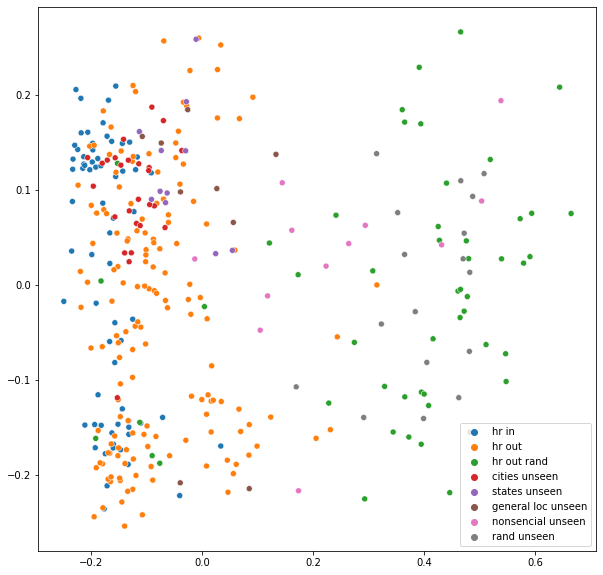

In [ ]:
# Qualitatively visualize the distinctions among embeddings of different 
# groups of (h, r)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(emb_all)
embedding_pca = pca.transform(emb_all)
plt.figure(figsize=(10,10))
sns.scatterplot(x=embedding_pca[:,0], y=embedding_pca[:,1], hue=hue)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(emb_all)
emb_tsne.shape

(348, 2)

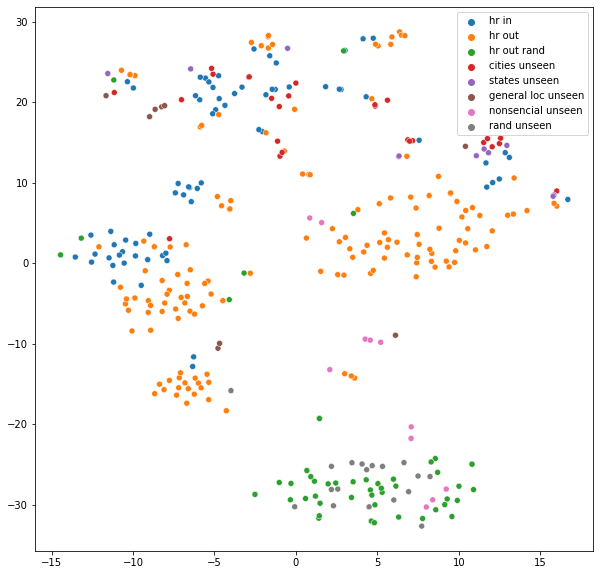

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=hue)

In [ ]:
new_sem = ['hr in', 'hr out', 'hr out rand', 'unseen',
           'unseen', 'unseen', 'rand unseen', 'rand unseen']

new_hue = []
for i, group in enumerate(emb_tuple):
    new_hue += [new_sem[i]] * group.shape[0]


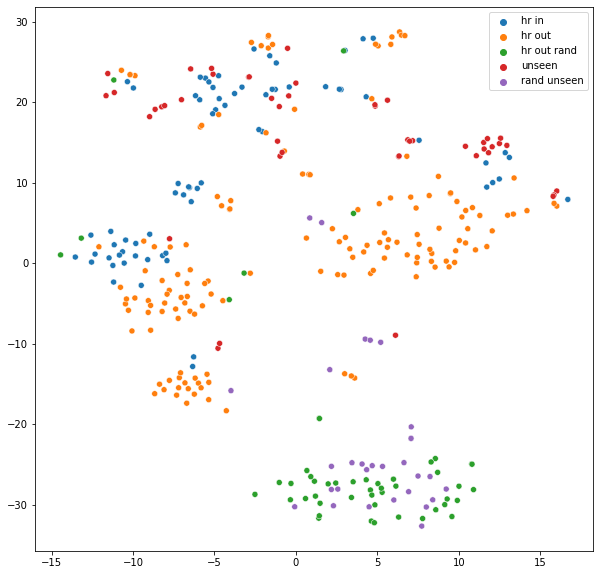

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=new_hue)

In [ ]:
# Check the tail prediction results for all the (h, r) above
entity_tensor = predictor.predict_by_entities(entities_dict.entity_exs)

100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


In [ ]:
print(entity_tensor.shape)

torch.Size([14541, 768])


In [ ]:
emb_tensor = torch.tensor(emb_all).cuda()
cosine_sim = emb_tensor.mm(entity_tensor.T)
print(cosine_sim.shape)

ranking = torch.argsort(cosine_sim, dim=1, descending=True)
print(ranking)

tensor_with_hr = torch.cat((entity_tensor, emb_tensor), dim=0)
sim_with_hr = emb_tensor.mm(tensor_with_hr.T)

ranking_with_hr = torch.argsort(sim_with_hr, dim=1, descending=True)
print(ranking_with_hr)

torch.Size([348, 14541])
tensor([[ 8450,  6386,  4005,  ...,  2973,  5873, 12768],
        [ 8450,  6386,  4005,  ..., 11104, 13636, 12768],
        [ 8450,  6386,  4005,  ...,  3345, 12768, 13636],
        ...,
        [ 6386,  8450,  4005,  ...,  1261,  3308,  6735],
        [ 6386,  8450,  4005,  ...,  5428,  1769,  2977],
        [ 6386,  8450,  4005,  ...,  3895,  5428,  6735]], device='cuda:0')
tensor([[14541, 14590, 14609,  ...,  2973,  5873, 12768],
        [14542, 14660, 14548,  ..., 11104, 13636, 12768],
        [14543, 14558, 14581,  ...,  3345, 12768, 13636],
        ...,
        [14886, 14871, 14766,  ...,  1261,  3308,  6735],
        [14887, 14883, 14763,  ...,  5428,  1769,  2977],
        [14888, 14789, 14879,  ...,  3895,  5428,  6735]], device='cuda:0')


In [ ]:
def print_sim_info(idx, ranking, top_k=10, skip_first=False):
    print(f'Entity: {idx},\tCategory: {hue[idx]},\tName: {emb_names[idx]}')

    iter_range = range(top_k) if not skip_first else range(1, top_k + 1)
    for i in iter_range:
        idx = ranking[i]
        rank = i if skip_first else i + 1
        if rank > 1 and (rank - 1) % 5 == 0:
            print()

        if idx < entity_tensor.shape[0]:
            print(f'{rank}: {entities_dict.entity_exs[idx].entity}', end=', ')
        else:
            print(f'{rank}: {emb_names[idx - entity_tensor.shape[0]]} (+rel)', end=', ')

    print('\n')


In [ ]:
# Check the similarity with entities only
for i in range(emb_tensor.shape[0]):
    print_sim_info(i, ranking[i], top_k=10, skip_first=False)

Entity: 0,	Category: hr in,	Name: Kitchener
1: Bus, 2: Air travel, 3: Train, 4: Rail transport, 5: Automobile, 
6: Travel, 7: Airline, 8: Hotel, 9: Television, 10: Retail-GB, 

Entity: 1,	Category: hr in,	Name: Los Angeles
1: Bus, 2: Air travel, 3: Train, 4: Automobile, 5: Travel, 
6: Rail transport, 7: Airline, 8: Hotel, 9: Retail-GB, 10: Restaurant, 

Entity: 2,	Category: hr in,	Name: Buffalo
1: Bus, 2: Air travel, 3: Train, 4: Automobile, 5: Travel, 
6: Rail transport, 7: Airline, 8: Hotel, 9: Retail-GB, 10: Sales, 

Entity: 3,	Category: hr in,	Name: Dublin
1: Bus, 2: Air travel, 3: Train, 4: Rail transport, 5: Automobile, 
6: Travel, 7: Airline, 8: Hotel, 9: Television, 10: Retail-GB, 

Entity: 4,	Category: hr in,	Name: Portland
1: Air travel, 2: Bus, 3: Train, 4: Travel, 5: Automobile, 
6: Rail transport, 7: Airline, 8: Hotel, 9: Retail-GB, 10: Sales, 

Entity: 5,	Category: hr in,	Name: Montreal
1: Bus, 2: Air travel, 3: Train, 4: Rail transport, 5: Automobile, 
6: Travel, 7: Airl

In [ ]:
# Check the similarity with entities and (h, r) pairs
for i in range(emb_tensor.shape[0]):
    print_sim_info(i, ranking_with_hr[i], top_k=10, skip_first=True)

Entity: 0,	Category: hr in,	Name: Kitchener
1: Waterloo (+rel), 2: Toronto (+rel), 3: St. Catharines (+rel), 4: Niagara Falls (+rel), 5: Montreal (+rel), 
6: Hamilton (+rel), 7: Ontario (+rel), 8: Vancouver (+rel), 9: Hamilton (+rel), 10: Austin (+rel), 

Entity: 1,	Category: hr in,	Name: Los Angeles
1: California (+rel), 2: Las Vegas (+rel), 3: Chicago (+rel), 4: San Francisco (+rel), 5: Santa Barbara (+rel), 
6: Anaheim (+rel), 7: Dallas (+rel), 8: Austin (+rel), 9: San Diego (+rel), 10: Long Beach (+rel), 

Entity: 2,	Category: hr in,	Name: Buffalo
1: Philadelphia (+rel), 2: Boston (+rel), 3: Dallas (+rel), 4: Chicago (+rel), 5: Burlington (+rel), 
6: New York City (+rel), 7: New Orleans (+rel), 8: Las Vegas (+rel), 9: Connecticut (+rel), 10: San Jose (+rel), 

Entity: 3,	Category: hr in,	Name: Dublin
1: London (+rel), 2: Amsterdam (+rel), 3: Birmingham (+rel), 4: Brussels (+rel), 5: Oslo (+rel), 
6: Southampton (+rel), 7: Wellington (+rel), 8: Luxembourg (+rel), 9: Madrid (+rel), 1

In [ ]:
# What is the rank of the highest-ranked entity?
for i in range(emb_tensor.shape[0]):
    for idx in range(sim_with_hr.shape[1]):
        if ranking_with_hr[i, idx] < entity_tensor.shape[0]:
            rank = idx
            break

    print(f'Entity: {i},\tCategory: {hue[i]},\tName: {emb_names[i]},\nTail entity highest rank: {rank}')

Entity: 0,	Category: hr in,	Name: Kitchener,
Tail entity highest rank: 292
Entity: 1,	Category: hr in,	Name: Los Angeles,
Tail entity highest rank: 306
Entity: 2,	Category: hr in,	Name: Buffalo,
Tail entity highest rank: 305
Entity: 3,	Category: hr in,	Name: Dublin,
Tail entity highest rank: 285
Entity: 4,	Category: hr in,	Name: Portland,
Tail entity highest rank: 302
Entity: 5,	Category: hr in,	Name: Montreal,
Tail entity highest rank: 294
Entity: 6,	Category: hr in,	Name: Amsterdam,
Tail entity highest rank: 281
Entity: 7,	Category: hr in,	Name: Las Vegas,
Tail entity highest rank: 304
Entity: 8,	Category: hr in,	Name: Vancouver,
Tail entity highest rank: 299
Entity: 9,	Category: hr in,	Name: Austin,
Tail entity highest rank: 296
Entity: 10,	Category: hr in,	Name: Wellington,
Tail entity highest rank: 292
Entity: 11,	Category: hr in,	Name: Sydney,
Tail entity highest rank: 285
Entity: 12,	Category: hr in,	Name: Singapore,
Tail entity highest rank: 294
Entity: 13,	Category: hr in,	Nam

### Fixed Entity, Varying Relations

In [ ]:
def check_diff_relations(head, head_desc, relations, top_k=10, no_desc=False):
    ex_list = []
    for rel in relations:
        ex_list.append(CustomExample(head, rel, dummy_tail, 
                                     head_desc if not no_desc else '', ''))
    
    hr_tensor, _ = predictor.predict_by_examples(ex_list)
    cos_sim = hr_tensor.mm(entity_tensor.T)

    ranking = torch.argsort(cos_sim, dim=1, descending=True)
    for i, rel in enumerate(relations):
        print(f'Entity: {head},\tRelation: {rel}')
        for rank in range(top_k):
            idx = ranking[i, rank]
            if rank > 0 and rank % 5 == 0:
                print()

            print(f'{rank + 1}: {entities_dict.entity_exs[idx].entity}', end=', ')

        print('\n')

In [ ]:
# Select some random relations
random.seed(477)
rand_rels = random.choices(relations, k=10)
print(rand_rels)

['campuses educational institution education ', 'special performance type performance actor film ', 'ethnicity people ', 'team sports team roster teams pro athlete sports ', 'nutrient nutrition fact nutrients food ', 'executive produced by film ', 'notable people with this condition disease medicine ', 'position football roster position current roster football team soccer ', 'instrumentalists instrument music ', 'group group membership regular performances performance role music ']


In [ ]:
# Check location entities within the dataset
head_id = list(head_in_ds)[0]
head = id2ent[head_id]
head_desc = entities_dict.get_entity_by_id(head_id).entity_desc

check_diff_relations(head, head_desc, rand_rels)

Entity: Kitchener,	Relation: campuses educational institution education 
1: University of Waterloo, 2: University of Western Ontario, 3: University of Guelph, 4: Queen's University, 5: University of Windsor, 
6: Upper Canada College, 7: Carleton University, 8: McMaster University, 9: University of Saskatchewan, 10: Ryerson University, 

Entity: Kitchener,	Relation: special performance type performance actor film 
1: Cameo appearance, 2: Playback Singer, 3: Deleted scene, 4: Contestant, 5: Puppeteer, 
6: Character Actor, 7: Seiyū-GB, 8: Master of Ceremonies-GB, 9: Guest host, 10: Boom Operator, 

Entity: Kitchener,	Relation: ethnicity people 
1: Canadian-American, 2: Scottish Canadian, 3: Acadians, 4: Sioux, 5: British Indian, 
6: Sikh, 7: Jewish people, 8: Sri Lankan Tamils, 9: Mizrahi Jews, 10: Malayali, 

Entity: Kitchener,	Relation: team sports team roster teams pro athlete sports 
1: Hamilton Bulldogs, 2: Toronto Maple Leafs, 3: Winnipeg Jets, 4: Ottawa Senators, 5: Calgary Flames,

In [ ]:
# Random entities in the dataset
random.seed(57)
head_id = random.choice(list(head_unrelated_in))
head = id2ent[head_id]
head_desc = entities_dict.get_entity_by_id(head_id).entity_desc

check_diff_relations(head, head_desc, rand_rels)

Entity: 13 Going on 30,	Relation: campuses educational institution education 
1: DeWitt Clinton High School, 2: Horace Mann School, 3: Tisch School of the Arts, 4: Beverly Hills High School, 5: Professional Children's School, 
6: Sarah Lawrence College, 7: Erasmus Hall High School, 8: Fiorello H. LaGuardia High School, 9: Hofstra University, 10: Long Island University, 

Entity: 13 Going on 30,	Relation: special performance type performance actor film 
1: Cameo appearance, 2: Contestant, 3: Deleted scene, 4: Playback Singer, 5: Guest host, 
6: Character Actor, 7: Announcer, 8: Master of Ceremonies-GB, 9: Spokesperson-GB, 10: Puppeteer, 

Entity: 13 Going on 30,	Relation: ethnicity people 
1: Italian American, 2: Irish American, 3: Hispanic and Latino Americans, 4: Cajun, 5: Italian people, 
6: German American, 7: Croatian American, 8: Russian American, 9: English American, 10: Puerto Rican people, 

Entity: 13 Going on 30,	Relation: team sports team roster teams pro athlete sports 
1: 

In [ ]:
# Locations unseen
random.seed(82)
idx = random.choice(range(len(cities_unseen)))
check_diff_relations(cities_unseen[idx], desc_cities_unseen[idx], rand_rels)

Entity: Winterthur,	Relation: campuses educational institution education 
1: University of Zurich, 2: ETH Zurich, 3: University of Basel, 4: University of Geneva, 5: University of Vienna, 
6: Technical University of Munich, 7: Albert Ludwigs University of Freiburg, 8: Polytechnic University of Milan, 9: Milan Conservatory, 10: Utrecht University, 

Entity: Winterthur,	Relation: special performance type performance actor film 
1: Playback Singer, 2: Cameo appearance, 3: Deleted scene, 4: Character Actor, 5: Contestant, 
6: Puppeteer, 7: Seiyū-GB, 8: Guest host, 9: Master of Ceremonies-GB, 10: Judge-GB, 

Entity: Winterthur,	Relation: ethnicity people 
1: Austrians, 2: Germans, 3: Romani people, 4: Italian people, 5: Swedes, 
6: Dutch people, 7: Bengali people, 8: Overseas Chinese, 9: European American, 10: French people, 

Entity: Winterthur,	Relation: team sports team roster teams pro athlete sports 
1: BSC Young Boys, 2: FC St. Gallen, 3: FC Basel, 4: Switzerland national football tea

In [ ]:
# Random unseen
random.seed(46)
idx = random.choice(range(len(random_unseen)))
check_diff_relations(random_unseen[idx], desc_random_unseen[idx], rand_rels)

Entity: Strand_Beach_Elevator,	Relation: campuses educational institution education 
1: California State University, Long Beach, 2: University of California, Santa Barbara, 3: University of California, Riverside, 4: Santa Monica College, 5: University of California, Santa Cruz, 
6: California State University, Los Angeles, 7: California State University, Northridge, 8: Pepperdine University, 9: Chapman University, 10: California State University, 

Entity: Strand_Beach_Elevator,	Relation: special performance type performance actor film 
1: Wally Wingert, 2: John Stephenson, 3: Mona Marshall, 4: Fred Tatasciore, 5: Estelle Harris, 
6: Bill Fagerbakke, 7: Kevin Michael Richardson, 8: Edie McClurg, 9: Lori Alan, 10: Nancy Cartwright, 

Entity: Strand_Beach_Elevator,	Relation: ethnicity people 
1: Swedish American, 2: Hispanic and Latino Americans, 3: Filipino American, 4: Puerto Rican people, 5: Asian American, 
6: Mexican American, 7: Italian American, 8: Croatian American, 9: Chinese Am

In [ ]:
# Sample a subset of entities and relations
num_samples = 50

head_in_all = list(head_in_ds) + list(head_unrelated_in) + list(head_filtered)
head_in_all_rel = list(head_in_ds) + list(head_filtered)
head_in_all_unrel = list(head_unrelated_in)

head_unseen = cities_unseen + states_unseen + locations_unseen + nonsensical_loc_unseen + random_unseen
head_rel_unseen = cities_unseen + states_unseen + locations_unseen
head_unrel_unseen = nonsensical_loc_unseen + random_unseen

desc_unseen = desc_cities_unseen + desc_states_unseen + desc_locations_unseen + desc_nonsensical_unseen + desc_random_unseen
desc_rel_unseen = desc_cities_unseen + desc_states_unseen + desc_locations_unseen
desc_unrel_unseen = desc_nonsensical_unseen + desc_random_unseen

head_in_sampled = random.sample(head_in_all, k=num_samples)
head_in_rel_sampled = random.sample(head_in_all_rel, k=num_samples)
head_in_unrel_sampled = random.sample(head_in_all_unrel, k=num_samples)

idx_sampled = random.sample(range(len(head_unseen)), k=min(num_samples, len(head_unseen)))
idx_rel_sampled = random.sample(range(len(head_rel_unseen)), k=min(num_samples, len(head_rel_unseen)))
idx_unrel_sampled = random.sample(range(len(head_unrel_unseen)), k=min(num_samples, len(head_unrel_unseen)))

print(f'Num head_in_all: {len(head_in_all)}')
print(f'Num head_in_all_rel: {len(head_in_all_rel)}')
print(f'Num head_in_all_unrel: {len(head_in_all_unrel)}')
print(f'Num head_unseen: {len(head_unseen)}')
print(f'Num head_rel_unseen: {len(head_rel_unseen)}')
print(f'Num head_unrel_unseen: {len(head_unrel_unseen)}')

head_unseen_sampled = [head_unseen[i] for i in idx_sampled]
desc_unseen_sampled = [head_unseen[i] for i in idx_sampled]

head_rel_unseen_sampled = [head_rel_unseen[i] for i in idx_rel_sampled]
desc_rel_unseen_sampled = [desc_rel_unseen[i] for i in idx_rel_sampled]

head_unrel_unseen_sampled = [head_unrel_unseen[i] for i in idx_unrel_sampled]
desc_unrel_unseen_sampled = [desc_unrel_unseen[i] for i in idx_unrel_sampled]

rel_sampled = random.sample(relations, k=num_samples)

Num head_in_all: 272
Num head_in_all_rel: 222
Num head_in_all_unrel: 50
Num head_unseen: 76
Num head_rel_unseen: 46
Num head_unrel_unseen: 30


In [ ]:
# Check the pair-wise similarity for different relations
def get_sim_single_ent_multi_rel(heads, rels, head_desc=None):
    sim_mean = []
    sim_var = []

    for i, head in enumerate(heads):
        exs = []

        if head_desc is None:
            for rel in rels:
                exs.append(Example(head, rel, dummy_tail))
        elif head_desc == '':
            for rel in rels:
                exs.append(CustomExample(head, rel, dummy_tail, '', ''))
        else:
            for rel in rels:
                exs.append(CustomExample(head, rel, dummy_tail, head_desc[i], ''))

        hr_tensor, _ = predictor.predict_by_examples(exs)
        num_hr = hr_tensor.shape[0]
        sim = hr_tensor.mm(hr_tensor.T)
        sim_sum = (torch.sum(sim) - num_hr) * 0.5
        mean = sim_sum / (num_hr * (num_hr - 1) * 0.5)

        sim_sq = sim * sim
        sim_sq_sum = (torch.sum(sim_sq) - num_hr) * 0.5
        sim_sq_mean = sim_sq_sum / (num_hr * (num_hr - 1) * 0.5)

        var = sim_sq_mean - mean ** 2
        sim_mean.append(mean.cpu().numpy())
        sim_var.append(var.cpu().numpy())

    print(f'Mean similarity: {np.mean(sim_mean)}')
    print(f'Similarity variance: {np.mean(sim_var)}')

In [ ]:
print('Similarity between single entity, multiple relations, averaged between all in-dataset entities:')
get_sim_single_ent_multi_rel(head_in_sampled, rel_sampled)

print()
print('Similarity between single entity, multiple relations, averaged between in-dataset related entities:')
get_sim_single_ent_multi_rel(head_in_rel_sampled, rel_sampled)

print()
print('Similarity between single entity, multiple relations, averaged between in-dataset unrelated entities:')
get_sim_single_ent_multi_rel(head_in_unrel_sampled, rel_sampled)

print()
print('Similarity between single entity, multiple relations, averaged between all out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_unseen_sampled, rel_sampled, desc_unseen_sampled)

print()
print('Similarity between single entity, multiple relations, averaged between related out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_rel_unseen_sampled, rel_sampled, desc_rel_unseen_sampled)

print()
print('Similarity between single entity, multiple relations, averaged between unrelated out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_unrel_unseen_sampled, rel_sampled, desc_unrel_unseen_sampled)

Similarity between single entity, multiple relations, averaged between all in-dataset entities:
Mean similarity: 0.16890469193458557
Similarity variance: 0.026132695376873016

Similarity between single entity, multiple relations, averaged between in-dataset related entities:
Mean similarity: 0.18386848270893097
Similarity variance: 0.025715194642543793

Similarity between single entity, multiple relations, averaged between in-dataset unrelated entities:
Mean similarity: 0.1794436275959015
Similarity variance: 0.02728564478456974

Similarity between single entity, multiple relations, averaged between all out-of-dataset entities:
Mean similarity: 0.12321057170629501
Similarity variance: 0.02164355479180813

Similarity between single entity, multiple relations, averaged between related out-of-dataset entities:
Mean similarity: 0.24816085398197174
Similarity variance: 0.026568951085209846

Similarity between single entity, multiple relations, averaged between unrelated out-of-dataset entit

In [ ]:
def get_sim_multi_ent_single_rel(heads, rels, head_desc=None):
    sim_mean = []
    sim_var = []

    for rel in rels:
        exs = []
        if head_desc is None:
            for head in heads:
                exs.append(Example(head, rel, dummy_tail))
        elif head_desc == '':
            for head in heads:
                exs.append(CustomExample(head, rel, dummy_tail, '', ''))
        else:
            for head, desc in zip(heads, head_desc):
                exs.append(CustomExample(head, rel, dummy_tail, desc, ''))

        hr_tensor, _ = predictor.predict_by_examples(exs)
        num_hr = hr_tensor.shape[0]
        sim = hr_tensor.mm(hr_tensor.T)
        sim_sum = (torch.sum(sim) - num_hr) * 0.5
        mean = sim_sum / (num_hr * (num_hr - 1) * 0.5)

        sim_sq = sim * sim
        sim_sq_sum = (torch.sum(sim_sq) - num_hr) * 0.5
        sim_sq_mean = sim_sq_sum / (num_hr * (num_hr - 1) * 0.5)

        var = sim_sq_mean - mean ** 2
        sim_mean.append(mean.cpu().numpy())
        sim_var.append(var.cpu().numpy())

    print(f'Mean similarity: {np.mean(sim_mean)}')
    print(f'Similarity variance: {np.mean(sim_var)}')

In [ ]:
print('Similarity between single relation, multiple in-dataset entities:')
get_sim_multi_ent_single_rel(head_in_sampled, rel_sampled)

print()
print('Similarity between single relation, multiple in-dataset related entities:')
get_sim_multi_ent_single_rel(head_in_rel_sampled, rel_sampled)

print()
print('Similarity between single relation, multiple in-dataset unrelated entities:')
get_sim_multi_ent_single_rel(head_in_unrel_sampled, rel_sampled)

print()
print('Similarity between single relation, multiple out-of-dataset entities:')
get_sim_multi_ent_single_rel(head_unseen_sampled, rel_sampled, desc_unseen_sampled)

print()
print('Similarity between single relation, multiple out-of-dataset related entities:')
get_sim_multi_ent_single_rel(head_rel_unseen_sampled, rel_sampled, desc_rel_unseen_sampled)

print()
print('Similarity between single relation, multiple out-of-dataset unrelated entities:')
get_sim_multi_ent_single_rel(head_unrel_unseen_sampled, rel_sampled, desc_unrel_unseen_sampled)

Similarity between single relation, multiple in-dataset entities:
Mean similarity: 0.6506310105323792
Similarity variance: 0.01853516884148121

Similarity between single relation, multiple in-dataset related entities:
Mean similarity: 0.6633260250091553
Similarity variance: 0.011516395024955273

Similarity between single relation, multiple in-dataset unrelated entities:
Mean similarity: 0.5956960916519165
Similarity variance: 0.019096441566944122

Similarity between single relation, multiple out-of-dataset entities:
Mean similarity: 0.8099830150604248
Similarity variance: 0.006692586001008749

Similarity between single relation, multiple out-of-dataset related entities:
Mean similarity: 0.65233314037323
Similarity variance: 0.01237986795604229

Similarity between single relation, multiple out-of-dataset unrelated entities:
Mean similarity: 0.6746327877044678
Similarity variance: 0.01594620756804943


### Repeat Same Set of Experiments without Descriptions

In [ ]:
# Reconstruct the examples without descriptions
ex_in = []
for ent in head_in_ds:
    ent_name = id2ent[ent]
    ex_in.append(CustomExample(ent_name, rel, dummy_tail, '', ''))

ex_out = []
for ent in head_filtered:
    ent_name = id2ent[ent]
    ex_out.append(CustomExample(ent_name, rel, dummy_tail, '', ''))

ex_out_rand = []
for ent in head_unrelated_in:
    ent_name = id2ent[ent]
    ex_out_rand.append(CustomExample(ent_name, rel, dummy_tail, '', ''))

ex_cities_unseen = []
for ent, desc in zip(cities_unseen, desc_cities_unseen):
    ex_cities_unseen.append(CustomExample(ent, rel, dummy_tail, '', ''))

ex_states_unseen = []
for ent, desc in zip(states_unseen, desc_states_unseen):
    ex_states_unseen.append(CustomExample(ent, rel, dummy_tail, '', ''))

ex_loc_unseen = []
for ent, desc in zip(locations_unseen, desc_locations_unseen):
    ex_loc_unseen.append(CustomExample(ent, rel, dummy_tail, '', ''))

ex_nonsense_unseen = []
for ent, desc in zip(nonsensical_loc_unseen, desc_nonsensical_unseen):
    ex_nonsense_unseen.append(CustomExample(ent, rel, dummy_tail, '', ''))

ex_random_unseen = []
for ent, desc in zip(random_unseen, desc_random_unseen):
    ex_random_unseen.append(CustomExample(ent, rel, dummy_tail, '', ''))

# Get the KGE of these (h, r) pairs
hr_in, _ = predictor.predict_by_examples(ex_in)
hr_out, _ = predictor.predict_by_examples(ex_out)
hr_out_rand, _ = predictor.predict_by_examples(ex_out_rand)
hr_cities_unseen, _ = predictor.predict_by_examples(ex_cities_unseen)
hr_states_unseen, _ = predictor.predict_by_examples(ex_states_unseen)
hr_loc_unseen, _ = predictor.predict_by_examples(ex_loc_unseen)
hr_nonsense_unseen, _ = predictor.predict_by_examples(ex_nonsense_unseen)
hr_random_unseen, _ = predictor.predict_by_examples(ex_random_unseen)

In [ ]:
emb_tuple = (hr_in, hr_out, hr_out_rand, hr_cities_unseen, hr_states_unseen, 
             hr_loc_unseen, hr_nonsense_unseen, hr_random_unseen)

emb_all = torch.cat(emb_tuple, 0).cpu().numpy()

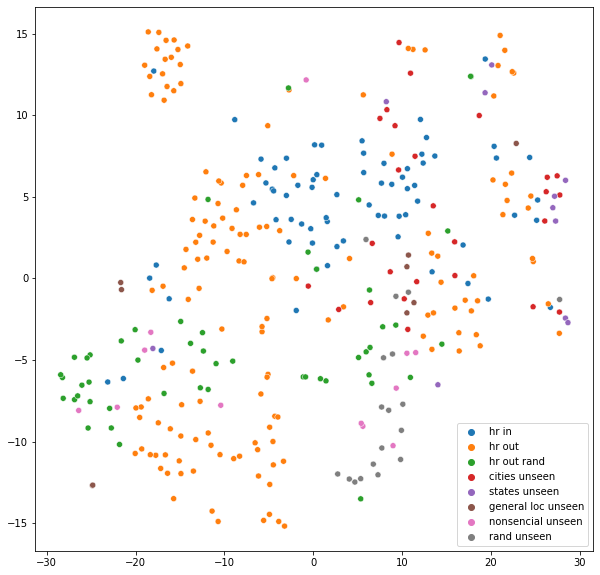

In [ ]:
# Directly visualize embedding distribution via T-SNE
emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(emb_all)
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=hue)

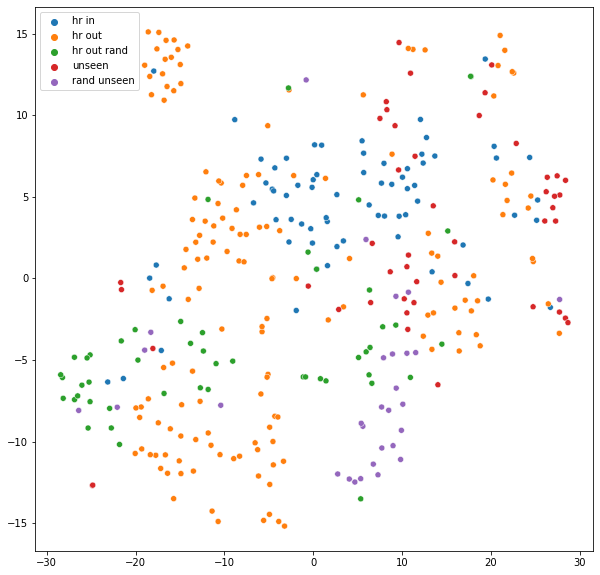

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=new_hue)

In [ ]:
emb_tensor = torch.tensor(emb_all).cuda()
cosine_sim = emb_tensor.mm(entity_tensor.T)
print(cosine_sim.shape)

ranking = torch.argsort(cosine_sim, dim=1, descending=True)
print(ranking)

tensor_with_hr = torch.cat((entity_tensor, emb_tensor), dim=0)
sim_with_hr = emb_tensor.mm(tensor_with_hr.T)

ranking_with_hr = torch.argsort(sim_with_hr, dim=1, descending=True)
print(ranking_with_hr)

torch.Size([348, 14541])
tensor([[ 6386,  4005,  8450,  ...,  5428,  3308,  6735],
        [ 6386,  8450,  4005,  ...,  3895,  5730,  5428],
        [ 6386,  8450,  4005,  ...,  3308,  5428,  6735],
        ...,
        [ 6386,  8450,  4005,  ..., 11626,  3308,  6735],
        [ 6386,  8450,  4005,  ...,  3308,  5428,  6735],
        [ 6386,  8450,  4005,  ..., 11626,  8442,  6735]], device='cuda:0')
tensor([[14541, 14590, 14593,  ...,  5428,  3308,  6735],
        [14542, 14630, 14627,  ...,  3895,  5730,  5428],
        [14543, 14550, 14808,  ...,  3308,  5428,  6735],
        ...,
        [14886, 14866, 14878,  ..., 11626,  3308,  6735],
        [14887, 14874, 14876,  ...,  3308,  5428,  6735],
        [14888, 14871, 14875,  ..., 11626,  8442,  6735]], device='cuda:0')


In [ ]:
# Check the similarity with entities only
for i in range(emb_tensor.shape[0]):
    print_sim_info(i, ranking[i], top_k=10, skip_first=False)

Entity: 0,	Category: hr in,	Name: Kitchener
1: Air travel, 2: Train, 3: Bus, 4: Travel, 5: Rail transport, 
6: Airline, 7: Hotel, 8: Automobile, 9: Munich, 10: Melbourne, 

Entity: 1,	Category: hr in,	Name: Los Angeles
1: Air travel, 2: Bus, 3: Train, 4: Travel, 5: Airline, 
6: Automobile, 7: Rail transport, 8: Hotel, 9: Restaurant, 10: Movie theater, 

Entity: 2,	Category: hr in,	Name: Buffalo
1: Air travel, 2: Bus, 3: Train, 4: Travel, 5: Rail transport, 
6: Airline, 7: Hotel, 8: Automobile, 9: Restaurant, 10: Melbourne, 

Entity: 3,	Category: hr in,	Name: Dublin
1: Air travel, 2: Bus, 3: Train, 4: Rail transport, 5: Travel, 
6: Airline, 7: Automobile, 8: Hotel, 9: Restaurant, 10: Hospitality, 

Entity: 4,	Category: hr in,	Name: Portland
1: Air travel, 2: Bus, 3: Train, 4: Travel, 5: Rail transport, 
6: Airline, 7: Hotel, 8: Automobile, 9: Restaurant, 10: Retail-GB, 

Entity: 5,	Category: hr in,	Name: Montreal
1: Air travel, 2: Bus, 3: Train, 4: Travel, 5: Rail transport, 
6: Airline

In [ ]:
# Check the similarity with entities and (h, r) pairs
for i in range(emb_tensor.shape[0]):
    print_sim_info(i, ranking_with_hr[i], top_k=10, skip_first=True)

Entity: 0,	Category: hr in,	Name: Kitchener
1: Waterloo (+rel), 2: Burlington (+rel), 3: Hamilton (+rel), 4: Hamilton (+rel), 5: Ontario (+rel), 
6: Wellington (+rel), 7: Buffalo (+rel), 8: Berlin (+rel), 9: Düsseldorf (+rel), 10: Southampton (+rel), 

Entity: 1,	Category: hr in,	Name: Los Angeles
1: Long Beach (+rel), 2: Santa Barbara (+rel), 3: New York City (+rel), 4: Capote (+rel), 5: Las Vegas (+rel), 
6: Connecticut (+rel), 7: Anaheim (+rel), 8: New Orleans (+rel), 9: Seattle (+rel), 10: Atlanta (+rel), 

Entity: 2,	Category: hr in,	Name: Buffalo
1: Austin (+rel), 2: Howard Shore (+rel), 3: Hamilton (+rel), 4: Hamilton (+rel), 5: Chicago (+rel), 
6: Virginia (+rel), 7: Wellington (+rel), 8: Birmingham (+rel), 9: Dallas (+rel), 10: Boston (+rel), 

Entity: 3,	Category: hr in,	Name: Dublin
1: Austin (+rel), 2: Amsterdam (+rel), 3: Munich (+rel), 4: Chicago (+rel), 5: Montreal (+rel), 
6: Miami (+rel), 7: Birmingham (+rel), 8: Paris (+rel), 9: Southampton (+rel), 10: Kiev (+rel), 



In [ ]:
# What is the rank of the highest-ranked entity?
for i in range(emb_tensor.shape[0]):
    for idx in range(sim_with_hr.shape[1]):
        if ranking_with_hr[i, idx] < entity_tensor.shape[0]:
            rank = idx
            break

    print(f'Entity: {i},\tCategory: {hue[i]},\tName: {emb_names[i]},\nTail entity highest rank: {rank}')

Entity: 0,	Category: hr in,	Name: Kitchener,
Tail entity highest rank: 348
Entity: 1,	Category: hr in,	Name: Los Angeles,
Tail entity highest rank: 348
Entity: 2,	Category: hr in,	Name: Buffalo,
Tail entity highest rank: 348
Entity: 3,	Category: hr in,	Name: Dublin,
Tail entity highest rank: 348
Entity: 4,	Category: hr in,	Name: Portland,
Tail entity highest rank: 348
Entity: 5,	Category: hr in,	Name: Montreal,
Tail entity highest rank: 348
Entity: 6,	Category: hr in,	Name: Amsterdam,
Tail entity highest rank: 348
Entity: 7,	Category: hr in,	Name: Las Vegas,
Tail entity highest rank: 348
Entity: 8,	Category: hr in,	Name: Vancouver,
Tail entity highest rank: 348
Entity: 9,	Category: hr in,	Name: Austin,
Tail entity highest rank: 348
Entity: 10,	Category: hr in,	Name: Wellington,
Tail entity highest rank: 348
Entity: 11,	Category: hr in,	Name: Sydney,
Tail entity highest rank: 348
Entity: 12,	Category: hr in,	Name: Singapore,
Tail entity highest rank: 347
Entity: 13,	Category: hr in,	Nam

### Fixed Entity, Varying Relations, No Descriptions

In [ ]:
# Check location entities within the dataset
head_id = list(head_in_ds)[0]
head = id2ent[head_id]
head_desc = entities_dict.get_entity_by_id(head_id).entity_desc

check_diff_relations(head, head_desc, rand_rels, no_desc=True)

Entity: Kitchener,	Relation: campuses educational institution education 
1: University of Waterloo, 2: University of Western Ontario, 3: University of Guelph, 4: University of Saskatchewan, 5: Carleton University, 
6: Queen's University, 7: University of Windsor, 8: Kitchener, 9: University of Ottawa, 10: University of Victoria, 

Entity: Kitchener,	Relation: special performance type performance actor film 
1: Cameo appearance, 2: Playback Singer, 3: Deleted scene, 4: Seiyū-GB, 5: Character Actor, 
6: Puppeteer, 7: Child actor-GB, 8: Clown, 9: Judge-GB, 10: Contestant, 

Entity: Kitchener,	Relation: ethnicity people 
1: Jewish people, 2: Poles, 3: Ashkenazi Jews, 4: Hungarian people, 5: Romani people, 
6: Mizrahi Jews, 7: Germans, 8: British Indian, 9: Canadian-American, 10: Polish American, 

Entity: Kitchener,	Relation: team sports team roster teams pro athlete sports 
1: Hamilton Bulldogs, 2: Washington Capitals, 3: Oklahoma City Barons, 4: Ottawa Senators, 5: Norfolk Admirals, 
6: 

In [ ]:
# Random entities in the dataset
random.seed(57)
head_id = random.choice(list(head_unrelated_in))
head = id2ent[head_id]
head_desc = entities_dict.get_entity_by_id(head_id).entity_desc

check_diff_relations(head, head_desc, rand_rels, no_desc=True)

Entity: 13 Going on 30,	Relation: campuses educational institution education 
1: Western Illinois University, 2: Northern Illinois University, 3: Central Michigan University, 4: Southern Illinois University Carbondale, 5: California Polytechnic State University, 
6: Illinois State University, 7: Fairfield University, 8: San Francisco State University, 9: Eastern Michigan University, 10: Western Michigan University, 

Entity: 13 Going on 30,	Relation: special performance type performance actor film 
1: Playback Singer, 2: Cameo appearance, 3: Character Actor, 4: Contestant, 5: Seiyū-GB, 
6: Deleted scene, 7: Strongman-GB, 8: Puppeteer, 9: Child actor-GB, 10: Guest host, 

Entity: 13 Going on 30,	Relation: ethnicity people 
1: Romani people, 2: Filipino, 3: Poles, 4: Russian, 5: Swedes, 
6: Jewish people, 7: Irish people, 8: Armenians, 9: Malayali, 10: Dutch people, 

Entity: 13 Going on 30,	Relation: team sports team roster teams pro athlete sports 
1: Oklahoma City Thunder, 2: Indiana 

In [ ]:
# Locations unseen
random.seed(82)
idx = random.choice(range(len(cities_unseen)))
check_diff_relations(cities_unseen[idx], desc_cities_unseen[idx], rand_rels, no_desc=True)

Entity: Winterthur,	Relation: campuses educational institution education 
1: University of Basel, 2: University of Zurich, 3: ETH Zurich, 4: Albert Ludwigs University of Freiburg, 5: University of Oslo, 
6: Ruprecht Karl University of Heidelberg, 7: University of Geneva, 8: Technical University of Munich, 9: Philipps University of Marburg, 10: University of Hamburg, 

Entity: Winterthur,	Relation: special performance type performance actor film 
1: Cameo appearance, 2: Playback Singer, 3: Character Actor, 4: Seiyū-GB, 5: Deleted scene, 
6: Puppeteer, 7: Stunt performer-GB, 8: Contestant, 9: Child actor-GB, 10: Judge-GB, 

Entity: Winterthur,	Relation: ethnicity people 
1: Germans, 2: Swedes, 3: Austrians, 4: Dutch people, 5: Russian, 
6: Romani people, 7: Poles, 8: Ashkenazi Jews, 9: French people, 10: Armenians, 

Entity: Winterthur,	Relation: team sports team roster teams pro athlete sports 
1: SC Freiburg, 2: BSC Young Boys, 3: Hamburger SV, 4: FC St. Gallen, 5: VfB Stuttgart, 
6: H

In [ ]:
# Random unseen
random.seed(46)
idx = random.choice(range(len(random_unseen)))
check_diff_relations(random_unseen[idx], desc_random_unseen[idx], rand_rels, no_desc=True)

Entity: Strand_Beach_Elevator,	Relation: campuses educational institution education 
1: California State University, Long Beach, 2: Florida International University, 3: Florida Atlantic University, 4: University of Sussex, 5: University of the West Indies, 
6: Rollins College, 7: University of Miami, 8: Santa Monica College, 9: Pepperdine University, 10: California State University, Los Angeles, 

Entity: Strand_Beach_Elevator,	Relation: special performance type performance actor film 
1: Playback Singer, 2: Cameo appearance, 3: Seiyū-GB, 4: Character Actor, 5: Deleted scene, 
6: Puppeteer, 7: Contestant, 8: Clown, 9: Voice Actor, 10: Stunt performer-GB, 

Entity: Strand_Beach_Elevator,	Relation: ethnicity people 
1: Dutch people, 2: Swedes, 3: Romani people, 4: English American, 5: Irish people, 
6: Dutch-American, 7: Jewish people, 8: Hispanic, 9: Asian American, 10: Filipino, 

Entity: Strand_Beach_Elevator,	Relation: team sports team roster teams pro athlete sports 
1: Chiba Lotte 

In [ ]:
# Sample a subset of entities and relations
num_samples = 50

head_in_all = list(head_in_ds) + list(head_unrelated_in) + list(head_filtered)
head_in_all_rel = list(head_in_ds) + list(head_filtered)
head_in_all_unrel = list(head_unrelated_in)

head_unseen = cities_unseen + states_unseen + locations_unseen + nonsensical_loc_unseen + random_unseen
head_rel_unseen = cities_unseen + states_unseen + locations_unseen
head_unrel_unseen = nonsensical_loc_unseen + random_unseen

desc_unseen = desc_cities_unseen + desc_states_unseen + desc_locations_unseen + desc_nonsensical_unseen + desc_random_unseen
desc_rel_unseen = desc_cities_unseen + desc_states_unseen + desc_locations_unseen
desc_unrel_unseen = desc_nonsensical_unseen + desc_random_unseen

head_in_sampled = random.sample(head_in_all, k=num_samples)
head_in_rel_sampled = random.sample(head_in_all_rel, k=num_samples)
head_in_unrel_sampled = random.sample(head_in_all_unrel, k=num_samples)

idx_sampled = random.sample(range(len(head_unseen)), k=min(num_samples, len(head_unseen)))
idx_rel_sampled = random.sample(range(len(head_rel_unseen)), k=min(num_samples, len(head_rel_unseen)))
idx_unrel_sampled = random.sample(range(len(head_unrel_unseen)), k=min(num_samples, len(head_unrel_unseen)))

print(f'Num head_in_all: {len(head_in_all)}')
print(f'Num head_in_all_rel: {len(head_in_all_rel)}')
print(f'Num head_in_all_unrel: {len(head_in_all_unrel)}')
print(f'Num head_unseen: {len(head_unseen)}')
print(f'Num head_rel_unseen: {len(head_rel_unseen)}')
print(f'Num head_unrel_unseen: {len(head_unrel_unseen)}')

head_unseen_sampled = [head_unseen[i] for i in idx_sampled]
desc_unseen_sampled = [head_unseen[i] for i in idx_sampled]

head_rel_unseen_sampled = [head_rel_unseen[i] for i in idx_rel_sampled]
desc_rel_unseen_sampled = [desc_rel_unseen[i] for i in idx_rel_sampled]

head_unrel_unseen_sampled = [head_unrel_unseen[i] for i in idx_unrel_sampled]
desc_unrel_unseen_sampled = [desc_unrel_unseen[i] for i in idx_unrel_sampled]

rel_sampled = random.sample(relations, k=num_samples)

Num head_in_all: 272
Num head_in_all_rel: 222
Num head_in_all_unrel: 50
Num head_unseen: 76
Num head_rel_unseen: 46
Num head_unrel_unseen: 30


In [ ]:
print('Similarity between single entity, multiple relations, averaged between all in-dataset entities:')
get_sim_single_ent_multi_rel(head_in_sampled, rel_sampled, '')

print()
print('Similarity between single entity, multiple relations, averaged between in-dataset related entities:')
get_sim_single_ent_multi_rel(head_in_rel_sampled, rel_sampled, '')

print()
print('Similarity between single entity, multiple relations, averaged between in-dataset unrelated entities:')
get_sim_single_ent_multi_rel(head_in_unrel_sampled, rel_sampled, '')

print()
print('Similarity between single entity, multiple relations, averaged between all out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_unseen_sampled, rel_sampled, '')

print()
print('Similarity between single entity, multiple relations, averaged between related out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_rel_unseen_sampled, rel_sampled, '')

print()
print('Similarity between single entity, multiple relations, averaged between unrelated out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_unrel_unseen_sampled, rel_sampled, '')

Similarity between single entity, multiple relations, averaged between all in-dataset entities:
Mean similarity: 0.10410212725400925
Similarity variance: 0.019639398902654648

Similarity between single entity, multiple relations, averaged between in-dataset related entities:
Mean similarity: 0.10484304279088974
Similarity variance: 0.019557708874344826

Similarity between single entity, multiple relations, averaged between in-dataset unrelated entities:
Mean similarity: 0.10525713115930557
Similarity variance: 0.019705593585968018

Similarity between single entity, multiple relations, averaged between all out-of-dataset entities:
Mean similarity: 0.12321057170629501
Similarity variance: 0.02164355479180813

Similarity between single entity, multiple relations, averaged between related out-of-dataset entities:
Mean similarity: 0.14181123673915863
Similarity variance: 0.02187597006559372

Similarity between single entity, multiple relations, averaged between unrelated out-of-dataset enti

In [ ]:
print('Similarity between single relation, multiple in-dataset entities:')
get_sim_multi_ent_single_rel(head_in_sampled, rel_sampled, '')

print()
print('Similarity between single relation, multiple in-dataset related entities:')
get_sim_multi_ent_single_rel(head_in_rel_sampled, rel_sampled, '')

print()
print('Similarity between single relation, multiple in-dataset unrelated entities:')
get_sim_multi_ent_single_rel(head_in_unrel_sampled, rel_sampled, '')

print()
print('Similarity between single relation, multiple out-of-dataset entities:')
get_sim_multi_ent_single_rel(head_unseen_sampled, rel_sampled, '')

print()
print('Similarity between single relation, multiple out-of-dataset related entities:')
get_sim_multi_ent_single_rel(head_rel_unseen_sampled, rel_sampled, '')

print()
print('Similarity between single relation, multiple out-of-dataset unrelated entities:')
get_sim_multi_ent_single_rel(head_unrel_unseen_sampled, rel_sampled, '')

Similarity between single relation, multiple in-dataset entities:
Mean similarity: 0.9477320313453674
Similarity variance: 0.0014941060217097402

Similarity between single relation, multiple in-dataset related entities:
Mean similarity: 0.9561473727226257
Similarity variance: 0.0008345949463546276

Similarity between single relation, multiple in-dataset unrelated entities:
Mean similarity: 0.9538882970809937
Similarity variance: 0.000893083808477968

Similarity between single relation, multiple out-of-dataset entities:
Mean similarity: 0.8099830150604248
Similarity variance: 0.006692586001008749

Similarity between single relation, multiple out-of-dataset related entities:
Mean similarity: 0.8017492890357971
Similarity variance: 0.006812451872974634

Similarity between single relation, multiple out-of-dataset unrelated entities:
Mean similarity: 0.8467249870300293
Similarity variance: 0.0047414470463991165


### Embedding Distribution of Reversed Relations

In [ ]:
from triplet import reverse_triplet

inv_rel = 'inverse {}'.format(rel)
print(inv_rel)

inverse mode of transportation transportation how to get here travel destination travel 


In [ ]:
# Continue to use the same set of entities as the head entities of the
# chosen inversed relation will be too few
dummy_tail = entities[0]['entity_id']

ex_in = []
for ent in head_in_ds:
    ex_in.append(Example(ent, inv_rel, dummy_tail))

ex_out = []
for ent in head_filtered:
    ex_out.append(Example(ent, inv_rel, dummy_tail))

ex_out_rand = []
for ent in head_unrelated_in:
    ex_out_rand.append(Example(ent, inv_rel, dummy_tail))

ex_cities_unseen = []
for ent, desc in zip(cities_unseen, desc_cities_unseen):
    ex_cities_unseen.append(CustomExample(ent, inv_rel, dummy_tail, desc, ''))

ex_states_unseen = []
for ent, desc in zip(states_unseen, desc_states_unseen):
    ex_states_unseen.append(CustomExample(ent, inv_rel, dummy_tail, desc, ''))

ex_loc_unseen = []
for ent, desc in zip(locations_unseen, desc_locations_unseen):
    ex_loc_unseen.append(CustomExample(ent, inv_rel, dummy_tail, desc, ''))

ex_nonsense_unseen = []
for ent, desc in zip(nonsensical_loc_unseen, desc_nonsensical_unseen):
    ex_nonsense_unseen.append(CustomExample(ent, inv_rel, dummy_tail, desc, ''))

ex_random_unseen = []
for ent, desc in zip(random_unseen, desc_random_unseen):
    ex_random_unseen.append(CustomExample(ent, inv_rel, dummy_tail, desc, ''))

# Get the KGE of these (h, r) pairs
hr_in, _ = predictor.predict_by_examples(ex_in)
hr_out, _ = predictor.predict_by_examples(ex_out)
hr_out_rand, _ = predictor.predict_by_examples(ex_out_rand)
hr_cities_unseen, _ = predictor.predict_by_examples(ex_cities_unseen)
hr_states_unseen, _ = predictor.predict_by_examples(ex_states_unseen)
hr_loc_unseen, _ = predictor.predict_by_examples(ex_loc_unseen)
hr_nonsense_unseen, _ = predictor.predict_by_examples(ex_nonsense_unseen)
hr_random_unseen, _ = predictor.predict_by_examples(ex_random_unseen)

print(hr_in.shape, hr_out.shape)

torch.Size([70, 768]) torch.Size([152, 768])


In [ ]:
emb_tuple = (hr_in, hr_out, hr_out_rand, hr_cities_unseen, hr_states_unseen, 
             hr_loc_unseen, hr_nonsense_unseen, hr_random_unseen)

emb_all_inv = torch.cat(emb_tuple, 0).cpu().numpy()

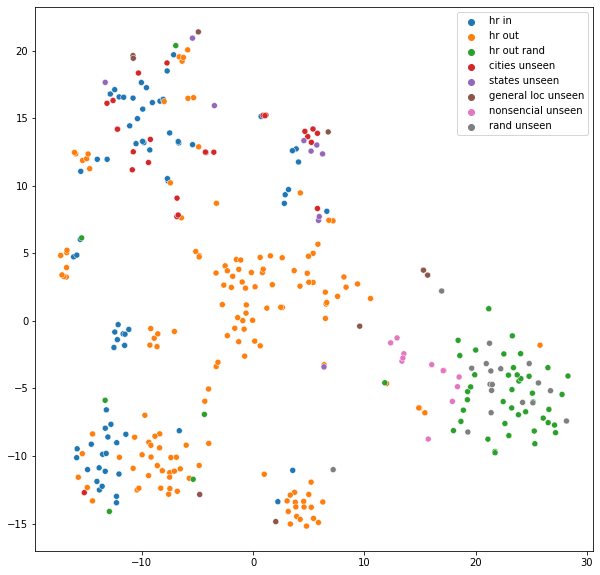

In [ ]:
# Directly visualize embedding distribution via T-SNE
emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(emb_all_inv)
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=hue)

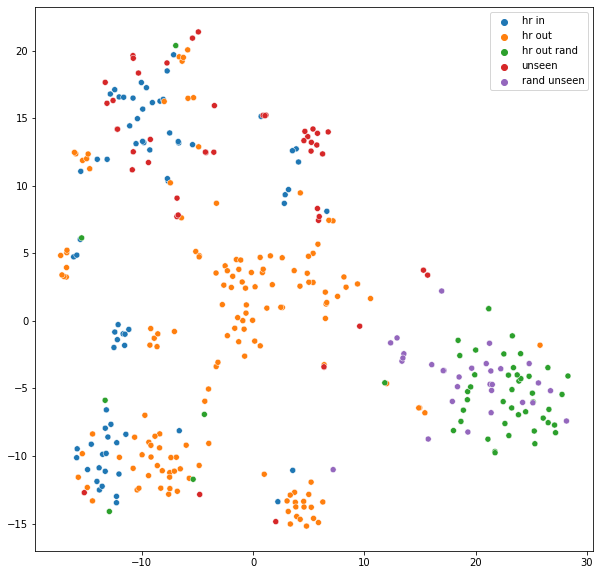

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=emb_tsne[:,0], y=emb_tsne[:,1], hue=new_hue)

In [ ]:
emb_tensor = torch.tensor(emb_all).cuda()
emb_tensor_inv = torch.tensor(emb_all_inv).cuda()
cosine_sim = emb_tensor_inv.mm(emb_tensor_inv.T)
print(cosine_sim.shape)

ranking = torch.argsort(cosine_sim, dim=1, descending=True)
print(ranking)

tensor_with_hr = torch.cat((entity_tensor, emb_tensor, emb_tensor_inv), dim=0)
sim_with_hr = emb_tensor_inv.mm(tensor_with_hr.T)

ranking_with_hr = torch.argsort(sim_with_hr, dim=1, descending=True)
print(ranking_with_hr)

torch.Size([348, 348])
tensor([[  0,  49,  68,  ..., 269, 226, 227],
        [  1, 119,  69,  ..., 269, 227, 268],
        [  2,  40,  17,  ..., 269, 234, 227],
        ...,
        [345, 225, 330,  ..., 151,  44,  11],
        [346, 245, 230,  ...,  29,  11,  44],
        [347, 309, 248,  ...,  44, 151,  11]], device='cuda:0')
tensor([[14889, 14938, 14957,  ...,  5873,  6735,  3308],
        [14890, 15008, 14958,  ..., 11843,  6735, 12768],
        [14891, 14929, 14906,  ...,  3520, 12768,  3308],
        ...,
        [15234, 15114, 15219,  ...,  1261,  3308,  6735],
        [15235, 15134, 15119,  ...,  9788,  3024,  6735],
        [15236, 15198, 15137,  ..., 14055,  7811,  6735]], device='cuda:0')


In [ ]:
# Slightly modified for inversed relations
def print_sim_info_inv(idx, ranking, top_k=10, skip_first=False):
    print(f'Entity: {idx},\tCategory: {hue[idx]},\tName: {emb_names[idx]}')

    iter_range = range(top_k) if not skip_first else range(1, top_k + 1)
    for i in iter_range:
        idx = ranking[i]
        rank = i if skip_first else i + 1
        if rank > 1 and (rank - 1) % 5 == 0:
            print()

        if idx < entity_tensor.shape[0]:
            print(f'{rank}: {entities_dict.entity_exs[idx].entity}', end=', ')
        elif idx < entity_tensor.shape[0] + emb_all.shape[0]:
            print(f'{rank}: {emb_names[idx - entity_tensor.shape[0]]} (+rel)', end=', ')
        else:
            ent_idx = idx - entity_tensor.shape[0] - emb_all.shape[0]
            print(f'{rank}: {emb_names[ent_idx]} (+inv_rel)', end=', ')

    print('\n')

In [ ]:
# Check the similarity with entities only
for i in range(emb_tensor_inv.shape[0]):
    print_sim_info_inv(i, ranking[i], top_k=10, skip_first=False)

Entity: 0,	Category: hr in,	Name: Kitchener
1: Dominican Republic, 2: Hunter S. Thompson, 3: Argentina, 4: DVD, 5: Dr. Dre, 
6: Star Trek Nemesis, 7: American History X, 8: Australia national association football team, 9: Sarah Lawrence College, 10: Triathlon, 

Entity: 1,	Category: hr in,	Name: Los Angeles
1: Republic, 2: Italy, 3: BAFTA Award for Best Makeup & Hair, 4: Portugal, 5: Naveen Andrews, 
6: Chris Cooper, 7: Alan Bennett, 8: Violin, 9: Billy Ray Cyrus, 10: Midfielder, 

Entity: 2,	Category: hr in,	Name: Buffalo
1: Mighty Morphin Power Rangers, 2: G.I. Joe: The Rise of Cobra, 3: Guy Pearce, 4: Violin, 5: Jackie Chan, 
6: Billy Ray Cyrus, 7: John Coltrane, 8: Richard Day, 9: Star Trek Nemesis, 10: Naveen Andrews, 

Entity: 3,	Category: hr in,	Name: Dublin
1: Wendee Lee, 2: United States of America, 3: Michelle Rodriguez, 4: 52nd Annual Grammy Awards-US, 5: The Purple Rose of Cairo, 
6: Period piece, 7: Dallas Cowboys, 8: 42nd Annual Grammy Awards, 9: Bridesmaids, 10: Denis Le

In [ ]:
# Check the similarity with entities and (h, r) pairs
for i in range(emb_tensor.shape[0]):
    print_sim_info_inv(i, ranking_with_hr[i], top_k=10, skip_first=True)

Entity: 0,	Category: hr in,	Name: Kitchener
1: Waterloo (+inv_rel), 2: Toronto (+inv_rel), 3: St. Catharines (+inv_rel), 4: Hamilton (+inv_rel), 5: Niagara Falls (+inv_rel), 
6: Montreal (+inv_rel), 7: Vancouver (+inv_rel), 8: Ontario (+inv_rel), 9: Newfoundland (+inv_rel), 10: Hamilton (+inv_rel), 

Entity: 1,	Category: hr in,	Name: Los Angeles
1: California (+inv_rel), 2: San Francisco (+inv_rel), 3: San Diego (+inv_rel), 4: Las Vegas (+inv_rel), 5: Anaheim (+inv_rel), 
6: Santa Barbara (+inv_rel), 7: New York City (+inv_rel), 8: Chicago (+inv_rel), 9: Austin (+inv_rel), 10: Atlanta (+inv_rel), 

Entity: 2,	Category: hr in,	Name: Buffalo
1: Boston (+inv_rel), 2: Philadelphia (+inv_rel), 3: New York City (+inv_rel), 4: New York (+inv_rel), 5: Chicago (+inv_rel), 
6: Burlington (+inv_rel), 7: Connecticut (+inv_rel), 8: Niagara Falls (+inv_rel), 9: Las Vegas (+inv_rel), 10: Charlotte (+inv_rel), 

Entity: 3,	Category: hr in,	Name: Dublin
1: London (+inv_rel), 2: Amsterdam (+inv_rel), 3:

In [ ]:
# Check the fixed entity with different inversed relations
rand_rels_inv = ['inverse {}'.format(rel) for rel in rand_rels]
print(rand_rels_inv)

['inverse campuses educational institution education ', 'inverse special performance type performance actor film ', 'inverse ethnicity people ', 'inverse team sports team roster teams pro athlete sports ', 'inverse nutrient nutrition fact nutrients food ', 'inverse executive produced by film ', 'inverse notable people with this condition disease medicine ', 'inverse position football roster position current roster football team soccer ', 'inverse instrumentalists instrument music ', 'inverse group group membership regular performances performance role music ']


In [ ]:
# Check location entities within the dataset
head_id = list(head_in_ds)[0]
head = id2ent[head_id]
head_desc = entities_dict.get_entity_by_id(head_id).entity_desc

check_diff_relations(head, head_desc, rand_rels_inv)

Entity: Kitchener,	Relation: inverse campuses educational institution education 
1: University of Waterloo, 2: University of Western Ontario, 3: University of Guelph, 4: Upper Canada College, 5: University of Windsor, 
6: Queen's University, 7: Carleton University, 8: University of Saskatchewan, 9: McMaster University, 10: Ryerson University, 

Entity: Kitchener,	Relation: inverse special performance type performance actor film 
1: Maurice LaMarche, 2: Tara Strong, 3: David Kaye, 4: Brian Drummond, 5: Tabitha St. Germain, 
6: Kathleen Barr, 7: Michael Ironside, 8: Jane Lynch, 9: Steve-O, 10: Samuel Vincent, 

Entity: Kitchener,	Relation: inverse ethnicity people 
1: Canadian-American, 2: Scottish Canadian, 3: Acadians, 4: Sioux, 5: Iroquois, 
6: Mizrahi Jews, 7: British Indian, 8: Jewish people, 9: Sikh, 10: Punjabi people, 

Entity: Kitchener,	Relation: inverse team sports team roster teams pro athlete sports 
1: Chris Pronger, 2: Dany Heatley, 3: Daniel Nestor, 4: Lars Hirschfeld, 5:

In [ ]:
# Random entities in the dataset
random.seed(57)
head_id = random.choice(list(head_unrelated_in))
head = id2ent[head_id]
head_desc = entities_dict.get_entity_by_id(head_id).entity_desc

check_diff_relations(head, head_desc, rand_rels_inv)

Entity: 13 Going on 30,	Relation: inverse campuses educational institution education 
1: DeWitt Clinton High School, 2: Horace Mann School, 3: Beverly Hills High School, 4: Professional Children's School, 5: Tisch School of the Arts, 
6: Erasmus Hall High School, 7: Sarah Lawrence College, 8: Santa Monica College, 9: Fiorello H. LaGuardia High School, 10: New Trier High School, 

Entity: 13 Going on 30,	Relation: inverse special performance type performance actor film 
1: David Koechner, 2: Molly Shannon, 3: Zach Galifianakis, 4: Stephen Root, 5: Terry Crews, 
6: Tara Reid, 7: Craig Robinson, 8: Debi Mazar, 9: Danny McBride, 10: Kaley Cuoco, 

Entity: 13 Going on 30,	Relation: inverse ethnicity people 
1: Italian American, 2: Irish American, 3: Hispanic and Latino Americans, 4: Cajun, 5: Italian people, 
6: Croatian American, 7: German American, 8: Russian American, 9: Caucasian race, 10: Greek American, 

Entity: 13 Going on 30,	Relation: inverse team sports team roster teams pro athl

In [ ]:
# Locations unseen
random.seed(82)
idx = random.choice(range(len(cities_unseen)))
check_diff_relations(cities_unseen[idx], desc_cities_unseen[idx], rand_rels_inv)

Entity: Winterthur,	Relation: inverse campuses educational institution education 
1: University of Zurich, 2: ETH Zurich, 3: University of Basel, 4: University of Geneva, 5: Technical University of Munich, 
6: Albert Ludwigs University of Freiburg, 7: University of Vienna, 8: Utrecht University, 9: Free University of Berlin, 10: University of Helsinki, 

Entity: Winterthur,	Relation: inverse special performance type performance actor film 
1: Udo Kier, 2: Nastassja Kinski, 3: Leslie Caron, 4: Colm Meaney, 5: Michael Gough, 
6: Sid James, 7: Milla Jovovich, 8: Molly Shannon, 9: Michelle Yeoh, 10: Til Schweiger, 

Entity: Winterthur,	Relation: inverse ethnicity people 
1: Austrians, 2: Germans, 3: Romani people, 4: Italian people, 5: Dutch people, 
6: Swedes, 7: Bengali people, 8: Ashkenazi Jews, 9: Overseas Chinese, 10: Hungarian people, 

Entity: Winterthur,	Relation: inverse team sports team roster teams pro athlete sports 
1: Alex Manninger, 2: Felix Bastians, 3: Roger Federer, 4: Hu

In [ ]:
# Random unseen
random.seed(46)
idx = random.choice(range(len(random_unseen)))
check_diff_relations(random_unseen[idx], desc_random_unseen[idx], rand_rels_inv)

Entity: Strand_Beach_Elevator,	Relation: inverse campuses educational institution education 
1: California State University, Long Beach, 2: Santa Monica College, 3: Chapman University, 4: University of California, Santa Barbara, 5: Saint Mary's College of California, 
6: Pepperdine University, 7: California State University, Northridge, 8: California State University, Los Angeles, 9: University of California, Riverside, 10: California State University, 

Entity: Strand_Beach_Elevator,	Relation: inverse special performance type performance actor film 
1: Estelle Harris, 2: Nancy Cartwright, 3: Edie McClurg, 4: Bill Fagerbakke, 5: Wally Wingert, 
6: John Stephenson, 7: Molly Shannon, 8: Fred Tatasciore, 9: Frank Welker, 10: Lori Alan, 

Entity: Strand_Beach_Elevator,	Relation: inverse ethnicity people 
1: Swedish American, 2: Filipino American, 3: Hispanic and Latino Americans, 4: Asian American, 5: Puerto Rican people, 
6: Mexican American, 7: Japanese American, 8: Chinese American, 9: 

In [ ]:
rel_sampled_inv = [f'inverse {rel}' for rel in rel_sampled]
print(rel_sampled_inv)

['inverse participant popstra base friendship celebrity popstra base ', 'inverse film art direction by film ', 'inverse participant popstra base breakup celebrity popstra base ', 'inverse family instrument music ', 'inverse peer relationship peers influence node influence ', 'inverse legislative sessions government position held members governmental body government ', 'inverse group group membership regular performances performance role music ', 'inverse award award honor awards won award winning work award ', 'inverse form of government country location ', 'inverse currency dated money value measurement unit net worth person extra schemastaging base ', 'inverse produced by film ', 'inverse current club x2010fifaworldcupsouthafrica base current world cup squad world cup squad x2010fifaworldcupsouthafrica base ', 'inverse legislative sessions government position held members legislative session government ', 'inverse nationality person people ', 'inverse major field of study students ma

In [ ]:
# Pair-wise similarities
print('Similarity between single entity, multiple inversed relations, averaged between all in-dataset entities:')
get_sim_single_ent_multi_rel(head_in_sampled, rel_sampled_inv)

print()
print('Similarity between single entity, multiple inversed relations, averaged between in-dataset related entities:')
get_sim_single_ent_multi_rel(head_in_rel_sampled, rel_sampled_inv)

print()
print('Similarity between single entity, multiple inversed relations, averaged between in-dataset unrelated entities:')
get_sim_single_ent_multi_rel(head_in_unrel_sampled, rel_sampled_inv)

print()
print('Similarity between single entity, multiple inversed relations, averaged between all out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_unseen_sampled, rel_sampled_inv, desc_unseen_sampled)

print()
print('Similarity between single entity, multiple inversed relations, averaged between related out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_rel_unseen_sampled, rel_sampled_inv, desc_rel_unseen_sampled)

print()
print('Similarity between single entity, multiple inversed relations, averaged between unrelated out-of-dataset entities:')
get_sim_single_ent_multi_rel(head_unrel_unseen_sampled, rel_sampled_inv, desc_unrel_unseen_sampled)

Similarity between single entity, multiple inversed relations, averaged between all in-dataset entities:
Mean similarity: 0.19875580072402954
Similarity variance: 0.03172273561358452

Similarity between single entity, multiple inversed relations, averaged between in-dataset related entities:
Mean similarity: 0.214228093624115
Similarity variance: 0.03156842663884163

Similarity between single entity, multiple inversed relations, averaged between in-dataset unrelated entities:
Mean similarity: 0.19941508769989014
Similarity variance: 0.031287215650081635

Similarity between single entity, multiple inversed relations, averaged between all out-of-dataset entities:
Mean similarity: 0.1291767954826355
Similarity variance: 0.023134641349315643

Similarity between single entity, multiple inversed relations, averaged between related out-of-dataset entities:
Mean similarity: 0.27674561738967896
Similarity variance: 0.032321058213710785

Similarity between single entity, multiple inversed relati

In [ ]:
print('Similarity between single inversed relation, multiple in-dataset entities:')
get_sim_multi_ent_single_rel(head_in_sampled, rel_sampled_inv)

print()
print('Similarity between single inversed relation, multiple in-dataset related entities:')
get_sim_multi_ent_single_rel(head_in_rel_sampled, rel_sampled_inv)

print()
print('Similarity between single inversed relation, multiple in-dataset unrelated entities:')
get_sim_multi_ent_single_rel(head_in_unrel_sampled, rel_sampled_inv)

print()
print('Similarity between single inversed relation, multiple out-of-dataset entities:')
get_sim_multi_ent_single_rel(head_unseen_sampled, rel_sampled_inv, desc_unseen_sampled)

print()
print('Similarity between single inversed relation, multiple out-of-dataset related entities:')
get_sim_multi_ent_single_rel(head_rel_unseen_sampled, rel_sampled_inv, desc_rel_unseen_sampled)

print()
print('Similarity between single inversed relation, multiple out-of-dataset unrelated entities:')
get_sim_multi_ent_single_rel(head_unrel_unseen_sampled, rel_sampled_inv, desc_unrel_unseen_sampled)

Similarity between single inversed relation, multiple in-dataset entities:
Mean similarity: 0.6039652824401855
Similarity variance: 0.019163478165864944

Similarity between single inversed relation, multiple in-dataset related entities:
Mean similarity: 0.6231658458709717
Similarity variance: 0.012213563546538353

Similarity between single inversed relation, multiple in-dataset unrelated entities:
Mean similarity: 0.5579089522361755
Similarity variance: 0.019749334082007408

Similarity between single inversed relation, multiple out-of-dataset entities:
Mean similarity: 0.7936837673187256
Similarity variance: 0.007238798774778843

Similarity between single inversed relation, multiple out-of-dataset related entities:
Mean similarity: 0.6176210641860962
Similarity variance: 0.014324026182293892

Similarity between single inversed relation, multiple out-of-dataset unrelated entities:
Mean similarity: 0.6418159008026123
Similarity variance: 0.018278971314430237


In [ ]:
# Check the similarity between forward and reversed relations
def get_sim_between_forward_reversed_rel(heads, forward_rels, head_desc=None):
    sim_all = []
    for rel in forward_rels:
        exs = []
        inv_exs = []
        inv_rel = f'inverse {rel}'

        if head_desc is None:
            for head in heads:
                exs.append(Example(head, rel, dummy_tail))
                inv_exs.append(Example(head, inv_rel, dummy_tail))
        else:
            for head, desc in zip(heads, head_desc):
                exs.append(CustomExample(head, rel, dummy_tail, desc, ''))
                inv_exs.append(CustomExample(head, inv_rel, dummy_tail, desc, ''))

        hr_tensor, _ = predictor.predict_by_examples(exs)
        hr_tensor_inv, _ = predictor.predict_by_examples(inv_exs)
        sim = torch.sum(hr_tensor * hr_tensor_inv, dim=1)
        sim_mean = torch.mean(sim).cpu().numpy()
        sim_all.append(sim_mean)

    print(f'Mean cosine similarity: {np.mean(sim_all)}')
    print(f'Similarity variance: {np.var(sim_all)}')

In [ ]:
# Similarity between a relation and its inverse, with the same head entities
print('Similarity between rel and inv_rel, averaged between all in-dataset entities:')
get_sim_between_forward_reversed_rel(head_in_sampled, rel_sampled)

print()
print('Similarity between rel and inv_rel, averaged between in-dataset related entities:')
get_sim_between_forward_reversed_rel(head_in_rel_sampled, rel_sampled)

print()
print('Similarity between rel and inv_rel, averaged between in-dataset unrelated entities:')
get_sim_between_forward_reversed_rel(head_in_unrel_sampled, rel_sampled)

print()
print('Similarity between rel and inv_rel, averaged between all out-of-dataset entities:')
get_sim_between_forward_reversed_rel(head_unseen_sampled, rel_sampled, desc_unseen_sampled)

print()
print('Similarity between rel and inv_rel, averaged between related out-of-dataset entities:')
get_sim_between_forward_reversed_rel(head_rel_unseen_sampled, rel_sampled, desc_rel_unseen_sampled)

print()
print('Similarity between rel and inv_rel, averaged between unrelated out-of-dataset entities:')
get_sim_between_forward_reversed_rel(head_unrel_unseen_sampled, rel_sampled, desc_unrel_unseen_sampled)

Similarity between rel and inv_rel, averaged between all in-dataset entities:
Mean cosine similarity: 0.8283948302268982
Similarity variance: 0.02588632144033909

Similarity between rel and inv_rel, averaged between in-dataset related entities:
Mean cosine similarity: 0.835425615310669
Similarity variance: 0.0246992539614439

Similarity between rel and inv_rel, averaged between in-dataset unrelated entities:
Mean cosine similarity: 0.8351622223854065
Similarity variance: 0.0200211089104414

Similarity between rel and inv_rel, averaged between all out-of-dataset entities:
Mean cosine similarity: 0.8365297913551331
Similarity variance: 0.023206844925880432

Similarity between rel and inv_rel, averaged between related out-of-dataset entities:
Mean cosine similarity: 0.8531447649002075
Similarity variance: 0.019297489896416664

Similarity between rel and inv_rel, averaged between unrelated out-of-dataset entities:
Mean cosine similarity: 0.8227906823158264
Similarity variance: 0.0241808369

In [ ]:
# Now check similarities between rel and inv_rel with different head entities
def get_sim_between_rel_inv(heads, rels, head_desc=None):
    sim_all = []
    for rel in rels:
        exs = []
        inv_exs = []
        inv_rel = f'inverse {rel}'

        if head_desc is None:
            for head in heads:
                exs.append(Example(head, rel, dummy_tail))
                inv_exs.append(Example(head, inv_rel, dummy_tail))
        elif head_desc == '':
            for head in heads:
                exs.append(CustomExample(head, rel, dummy_tail, '', ''))
                inv_exs.append(CustomExample(head, inv_rel, dummy_tail, '', ''))
        else:
            for head, desc in zip(heads, head_desc):
                exs.append(CustomExample(head, rel, dummy_tail, desc, ''))
                inv_exs.append(CustomExample(head, inv_rel, dummy_tail, desc, ''))

        hr_tensor, _ = predictor.predict_by_examples(exs)
        hr_tensor_inv, _ = predictor.predict_by_examples(inv_exs)

        num_hr = hr_tensor.shape[0]
        sim = hr_tensor.mm(hr_tensor_inv.T)
        sim_sum = (torch.sum(sim) - torch.sum(torch.diagonal(sim))) * 0.5
        mean = sim_sum / (num_hr * (num_hr - 1) * 0.5)

        sim_all.append(mean.cpu().numpy())

    print(f'Mean similarity: {np.mean(sim_all)}')
    print(f'Similarity variance: {np.var(sim_all)}')

In [ ]:
# Similarities between rel and inv_rel with different head entities
print('Similarity between rel and inv_rel, averaged between all in-dataset entities:')
get_sim_between_rel_inv(head_in_sampled, rel_sampled)

print()
print('Similarity between rel and inv_rel, averaged between in-dataset related entities:')
get_sim_between_rel_inv(head_in_rel_sampled, rel_sampled)

print()
print('Similarity between rel and inv_rel, averaged between in-dataset unrelated entities:')
get_sim_between_rel_inv(head_in_unrel_sampled, rel_sampled)

print()
print('Similarity between rel and inv_rel, averaged between all out-of-dataset entities:')
get_sim_between_rel_inv(head_unseen_sampled, rel_sampled, desc_unseen_sampled)

print()
print('Similarity between rel and inv_rel, averaged between related out-of-dataset entities:')
get_sim_between_rel_inv(head_rel_unseen_sampled, rel_sampled, desc_rel_unseen_sampled)

print()
print('Similarity between rel and inv_rel, averaged between unrelated out-of-dataset entities:')
get_sim_between_rel_inv(head_unrel_unseen_sampled, rel_sampled, desc_unrel_unseen_sampled)

Similarity between rel and inv_rel, averaged between all in-dataset entities:
Mean similarity: 0.5150505304336548
Similarity variance: 0.04493694379925728

Similarity between rel and inv_rel, averaged between in-dataset related entities:
Mean similarity: 0.5316663384437561
Similarity variance: 0.0454292818903923

Similarity between rel and inv_rel, averaged between in-dataset unrelated entities:
Mean similarity: 0.47644808888435364
Similarity variance: 0.03481092303991318

Similarity between rel and inv_rel, averaged between all out-of-dataset entities:
Mean similarity: 0.6726022958755493
Similarity variance: 0.041504934430122375

Similarity between rel and inv_rel, averaged between related out-of-dataset entities:
Mean similarity: 0.53043532371521
Similarity variance: 0.03880642354488373

Similarity between rel and inv_rel, averaged between unrelated out-of-dataset entities:
Mean similarity: 0.5394546985626221
Similarity variance: 0.03596791252493858


### Relation Extrapolation

In [ ]:
# Get the original FB15k dataset
!wget https://data.deepai.org/FB15K.zip
!unzip FB15K.zip

--2022-07-12 09:05:02--  https://data.deepai.org/FB15K.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17445519 (17M) [application/x-zip-compressed]
Saving to: ‘FB15K.zip’

FB15K.zip           100%[===================>]  16.64M  7.55MB/s    in 2.2s    

2022-07-12 09:05:06 (7.55 MB/s) - ‘FB15K.zip’ saved [17445519/17445519]

Archive:  FB15K.zip
   creating: FB15K/
  inflating: FB15K/entity2wikidata.json  
   creating: FB15K/original/
  inflating: FB15K/original/FB15k.tar.xz  
  inflating: FB15K/test.txt          
  inflating: FB15K/train.txt         
  inflating: FB15K/valid.txt         


In [ ]:
# Preprocess FB15k relations
def _normalize_fb15k237_relation(relation: str) -> str:
    tokens = relation.replace('./', '/').replace('_', ' ').strip().split('/')
    dedup_tokens = []
    for token in tokens:
        if token not in dedup_tokens[-3:]:
            dedup_tokens.append(token)
    # leaf words are more important (maybe)
    relation_tokens = dedup_tokens[::-1]
    relation = ' '.join([t for idx, t in enumerate(relation_tokens)
                         if idx == 0 or relation_tokens[idx] != relation_tokens[idx - 1]])
    return relation

fb15k_files = ['FB15K/train.txt', 'FB15K/test.txt', 'FB15K/valid.txt']
fb15k_rels = set()
for path in fb15k_files:
    with open(path) as f:
        lines = f.readlines()
        rels = [line.split()[1] for line in lines]
        fb15k_rels.update(set(rels))

fb15k_rels = list(fb15k_rels)
print(f'Num relations: {len(fb15k_rels)}')
print(fb15k_rels[:5])
print()

fb15k_rels = [_normalize_fb15k237_relation(rel) for rel in fb15k_rels]
fb15k_rels = list(set(fb15k_rels))
print(f'After processing:')
print(f'Num relations: {len(fb15k_rels)}')
print(fb15k_rels[:5])

Num relations: 1345
['/user/alexander/philosophy/philosopher/era', '/tv/tv_producer/tv_episodes_produced./tv/tv_producer_episode_credit/episode', '/tv/tv_series_episode/series', '/sports/sports_team/colors', '/base/americancomedy/comedy_genre/comedians_in_this_genre']

After processing:
Num relations: 1343
['computer models computer manufacturer brand computer ', 'agencies governmental jurisdiction government ', 'games cvg genre cvg ', 'religious text of religious text religion ', 'organizations merging organization merger involved in merger organization ']


In [ ]:
# Filter out relations already exist in FB15k237
fb15k_rels_filtered = []
for rel in fb15k_rels:
    if rel not in relations:
        fb15k_rels_filtered.append(rel)

print(f'Num relations not in FB15k237: {len(fb15k_rels_filtered)}')

Num relations not in FB15k237: 1106


In [ ]:
# Get all the examples in the FB15k which have unseen relations 
# but seen entities
fb15k_exs = []

for path in fb15k_files:
    with open(path) as f:
        lines = f.readlines()
        for line in lines:
            head_id, rel, tail_id = line.split()
            rel = _normalize_fb15k237_relation(rel)
            if rel in relations:
                continue
            if head_id not in id2ent.keys() or tail_id not in id2ent.keys():
                continue

            fb15k_exs.append(Example(head_id, rel, tail_id))

print(f'Num examples: {len(fb15k_exs)}')

Num examples: 243112


In [ ]:
# Only select relations with entities appearing in FB15k237
fb15k_rels_filtered = []
for ex in fb15k_exs:
    fb15k_rels_filtered.append(ex.relation)

fb15k_rels_filtered = list(set(fb15k_rels_filtered))

print(f'Num relations not in FB15k237 but with entities in FB15k237: {len(fb15k_rels_filtered)}')

Num relations not in FB15k237 but with entities in FB15k237: 949


In [ ]:
# Print out some of these relations
print(fb15k_rels_filtered[:10])

['second level division of administrative division location ', 'innovator original idea argumentmaps base ', 'active moiety of drug drug ingredient medicine ', 'currency dated money value measurement unit current liabilities business operation business ', 'team batting statistics batting stats baseball player baseball ', 'person employment tenure employees employer business ', 'convicted person criminal conviction crime base convictions sentence fight base ', 'player baseball roster position current roster baseball team baseball ', 'agencies governmental jurisdiction government ', 'athlete olympic athlete affiliation athletes olympic sport olympics ']


In [ ]:
# Sample some relations
num_rel_samples = 30

random.seed(24)
rel_unseen = random.sample(fb15k_rels_filtered, k=num_rel_samples)
print(rel_unseen)

['flight destination airliner accident aviation ', 'developer operating system computer ', 'nobel prize winner nobel honor nobelprizes base nobel awards nobel subject area nobelprizes base ', 'subdisciplines field of study education ', 'team football historical coach position coaching history football coach american football ', 'seasons regular tv appearance starring roles tv actor tv ', 'position football roster position soccer roster sports team sports ', 'office position or title government position held members legislative session government ', 'things of this type type of thing onephylogeny base ', 'activist organizations activism issue activism base ', 'parent category collection category interests ', 'position football roster position current team football player american football ', 'team basketball player stats player statistics basketball player basketball ', 'companies industry business ', 'alliance airline aviation ', 'government positions governmental jurisdiction governme

In [ ]:
# For each relation, we sample some of its head entities and check the
# similarity with all other entities
def check_unseen_rel_sim(rel, num_ent=1, top_k=10, inversed=False):
    ent_list = []
    for ex in fb15k_exs:
        if ex.relation == rel:
            ent_list.append((ex.head_id, ex.tail_id))

    inv_rel = f'inverse {rel}'

    ent_list = list(set(ent_list))
    ents = random.sample(ent_list, k=num_ent)
    exs = []
    for ent in ents:
        if not inversed:
            exs.append(Example(ent[0], rel, dummy_tail))
        else:
            exs.append(Example(ent[1], inv_rel, dummy_tail))

    hr_tensor, _ = predictor.predict_by_examples(exs)
    sim = hr_tensor.mm(entity_tensor.T)
    ranking = torch.argsort(sim, dim=1, descending=True)

    for i, ent in enumerate(ents):
        if not inversed:
            print(f'Head: {id2ent[ent[0]]},\tRelation: {rel},\tGT tail: {id2ent[ent[1]]}')
        else:
            print(f'Head: {id2ent[ent[1]]},\tRelation: {inv_rel},\tGT tail: {id2ent[ent[0]]}')

        for rank in range(top_k):
            if rank > 0 and rank % 5 == 0:
                print()

            print(f'{rank + 1}: {entities_dict.entity_exs[ranking[i, rank]].entity}', end=', ')

        print('\n')


In [ ]:
for rel in rel_unseen:
    check_unseen_rel_sim(rel)

Head: The Delta Force,	Relation: flight destination airliner accident aviation ,	GT tail: John F. Kennedy International Airport
1: Air travel, 2: Los Angeles International Airport, 3: John F. Kennedy International Airport, 4: Airline, 5: Traffic collision, 
6: Aviation, 7: Volcano, 8: Sydney Airport, 9: Dallas, 10: Logan International Airport, 

Head: Windows XP,	Relation: developer operating system computer ,	GT tail: Microsoft Corporation
1: Microsoft Windows, 2: Windows XP, 3: Windows Vista, 4: GNU/Linux, 5: FreeBSD, 
6: OS X, 7: Solaris Operating System, 8: Havok, 9: Microsoft Corporation, 10: RenderWare, 

Head: Global warming,	Relation: nobel prize winner nobel honor nobelprizes base nobel awards nobel subject area nobelprizes base ,	GT tail: Al Gore
1: Ernest Rutherford, 2: Stephen Hawking, 3: Richard Feynman, 4: Albert Einstein, 5: Linus Pauling, 
6: Niels Henrik David Bohr, 7: Enrico Fermi, 8: John Maynard Keynes, 9: Richard Dawkins, 10: Winston Churchill, 

Head: Philosophy,	

In [ ]:
# Check the backward direction
for rel in rel_unseen:
    check_unseen_rel_sim(rel, inversed=True)

Head: John F. Kennedy International Airport,	Relation: inverse flight destination airliner accident aviation ,	GT tail: The Delta Force
1: Traffic collision, 2: Air travel, 3: Gunshot, 4: Drug overdose, 5: John F. Kennedy International Airport, 
6: Respiratory failure, 7: Assassination, 8: Aviation, 9: Stroke, 10: Natural causes, 

Head: Apple Inc.,	Relation: inverse developer operating system computer ,	GT tail: OS X
1: OS X, 2: Microsoft Windows, 3: GNU/Linux, 4: Windows XP, 5: Solaris Operating System, 
6: Unix, 7: Windows Vista, 8: Android, 9: Havok, 10: Computer hardware, 

Head: J. M. Coetzee,	Relation: inverse nobel prize winner nobel honor nobelprizes base nobel awards nobel subject area nobelprizes base ,	GT tail: Literature
1: Public health, 2: Technology, 3: Biotechnology, 4: Science, 5: Evolution, 
6: Education, 7: Marketing-GB, 8: Artificial intelligence, 9: Ecology, 10: Health care, 

Head: Electrical engineering,	Relation: inverse subdisciplines field of study education 

In [ ]:
# We then check the similarity between unseen relations and seen relations
def check_sim_between_relations(rel, inversed=False, top_k=5):
    ent_list = []
    for ex in fb15k_exs:
        if ex.relation == rel:
            ent_list.append((ex.head_id, ex.tail_id))

    inv_rel = f'inverse {rel}'

    ent_list = list(set(ent_list))
    ent = random.choice(ent_list)

    if inversed:
        exs = [Example(ent[1], inv_rel, ent[0])]
    else:
        exs = [Example(ent[0], rel, ent[1])]

    for r in relations:
        if inversed:
            exs.append(Example(ent[1], r, ent[0]))
        else:
            exs.append(Example(ent[0], r, ent[1]))

    for r in relations:
        inv_r = f'inverse {r}'
        if inversed:
            exs.append(Example(ent[1], inv_r, ent[0]))
        else:
            exs.append(Example(ent[0], inv_r, ent[1]))

    hr_tensor, _ = predictor.predict_by_examples(exs)
    sim = hr_tensor[0, None].mm(hr_tensor[1:].T)
    ranking = torch.argsort(sim, dim=1, descending=True)

    print(f'Head: {id2ent[ent[0]] if not inversed else id2ent[ent[1]]},\tRelation: {inv_rel if inversed else rel}')
    for rank in range(top_k):
        idx = ranking[0, rank]
        if idx < len(relations):
            print(f'{rank + 1}: {relations[idx]}, sim: {sim[0, idx]}')
        else:
            print(f'{rank + 1}: inverse {relations[idx - len(relations)]}, sim: {sim[0, idx]}')
    

In [ ]:
for rel in rel_unseen:
    check_sim_between_relations(rel)
    print()

Head: The Delta Force,	Relation: flight destination airliner accident aviation 
1: inverse mode of transportation transportation how to get here travel destination travel , sim: 0.6242507696151733
2: mode of transportation transportation how to get here travel destination travel , sim: 0.5347087383270264
3: locations event time , sim: 0.5072271823883057
4: service location phone sandbox schemastaging base phone number organization extra schemastaging base , sim: 0.5011924505233765
5: inverse locations event time , sim: 0.49977347254753113

Head: Windows Vista,	Relation: developer operating system computer 
1: inverse nominated for award nomination award nominations award nominee award , sim: 0.8435295224189758
2: award honor awards won award winner award , sim: 0.8267878293991089
3: inverse award honor awards won award winner award , sim: 0.8267812728881836
4: award winner award honor awards won award winning work award , sim: 0.8149523735046387
5: inverse industry business operation b

In [ ]:
for rel in rel_unseen:
    check_sim_between_relations(rel, inversed=True)
    print()

Head: John F. Kennedy International Airport,	Relation: inverse flight destination airliner accident aviation 
1: inverse cause of death people , sim: 0.4983321726322174
2: cause of death people , sim: 0.49807941913604736
3: inverse entity involved event culturalevent base , sim: 0.4923272430896759
4: inverse locations event time , sim: 0.4649043679237366
5: inverse split to gardening hint dataworld , sim: 0.45562976598739624

Head: Microsoft Corporation,	Relation: inverse developer operating system computer 
1: inverse industry business operation business , sim: 0.7324250936508179
2: inverse split to gardening hint dataworld , sim: 0.6952294111251831
3: split to gardening hint dataworld , sim: 0.6931939125061035
4: organizations founded organization founder organization , sim: 0.6008566617965698
5: nominated for award nomination award nominations award nominee award , sim: 0.5830459594726562

Head: Rabindranath Tagore,	Relation: inverse nobel prize winner nobel honor nobelprizes base n

In [ ]:
# See the similarity between unseen rel and its inverse
def check_sim_unseen_rel_inv(rel, num_ent=30):
    ents = random.sample(entities_dict.entity_exs, k=num_ent)
    ents = [x.entity_id for x in ents]

    exs = []
    inv_exs = []
    inv_rel = f'inverse {rel}'
    for ent in ents:
        exs.append(Example(ent, rel, dummy_tail))
        inv_exs.append(Example(ent, inv_rel, dummy_tail))

    hr, _ = predictor.predict_by_examples(exs)
    hr_inv, _ = predictor.predict_by_examples(inv_exs)

    sim = hr.mm(hr_inv.T)
    tri_idx = torch.triu_indices(sim.shape[0], sim.shape[1])
    sim = sim[tri_idx[0], tri_idx[1]]
    print(f'Relation: {rel}')
    print(f'Mean similarity: {torch.mean(sim)}')
    print(f'Similarity variance: {torch.var(sim)}')


In [ ]:
for rel in rel_unseen:
    check_sim_unseen_rel_inv(rel)
    print()

Relation: flight destination airliner accident aviation 
Mean similarity: 0.7451513409614563
Similarity variance: 0.00759791349992156

Relation: developer operating system computer 
Mean similarity: 0.6910118460655212
Similarity variance: 0.012527082115411758

Relation: nobel prize winner nobel honor nobelprizes base nobel awards nobel subject area nobelprizes base 
Mean similarity: 0.7574927806854248
Similarity variance: 0.017110761255025864

Relation: subdisciplines field of study education 
Mean similarity: 0.7340778708457947
Similarity variance: 0.009256257675588131

Relation: team football historical coach position coaching history football coach american football 
Mean similarity: 0.530101478099823
Similarity variance: 0.016133839264512062

Relation: seasons regular tv appearance starring roles tv actor tv 
Mean similarity: 0.3038223385810852
Similarity variance: 0.05977920442819595

Relation: position football roster position soccer roster sports team sports 
Mean similarity: 0.

### Zero-shot Performance on FB15k

In [ ]:
# Convert examples to json
import json

json_out = 'fb15k_test.json'
json_list = []
for ex in fb15k_exs:
    json_dict = {
        'head_id': ex.head_id,
        'head': ex.head,
        'relation': ex.relation,
        'tail_id': ex.tail_id,
        'tail': ex.tail
    }
    json_list.append(json_dict)

with open(json_out, 'w') as f:
    json.dump(json_list, f)

In [ ]:
class ExampleWithoutDesc(Example):

    def __init__(self, head_id, relation, tail_id, **kwargs):
        super().__init__(head_id, relation, tail_id)

    def vectorize(self) -> dict:
        head_word = _parse_entity_name(self.head)
        head_text = head_word
        hr_encoded_inputs = _custom_tokenize(text=head_text,
                                             text_pair=self.relation)

        head_encoded_inputs = _custom_tokenize(text=head_text)

        tail_word = _parse_entity_name(self.tail)
        tail_encoded_inputs = _custom_tokenize(text=tail_word)

        return {'hr_token_ids': hr_encoded_inputs['input_ids'],
                'hr_token_type_ids': hr_encoded_inputs['token_type_ids'],
                'tail_token_ids': tail_encoded_inputs['input_ids'],
                'tail_token_type_ids': tail_encoded_inputs['token_type_ids'],
                'head_token_ids': head_encoded_inputs['input_ids'],
                'head_token_type_ids': head_encoded_inputs['token_type_ids'],
                'obj': self}

In [ ]:
# Modified evaluation functions
from doc import load_data
from evaluate import compute_metrics, PredInfo
from time import time
from dataclasses import dataclass, asdict

def predict_by_split(use_desc=True):
    forward_metrics = eval_single_direction(predictor,
                                            entity_tensor=entity_tensor,
                                            eval_forward=True,
                                            use_desc=use_desc)
    backward_metrics = eval_single_direction(predictor,
                                             entity_tensor=entity_tensor,
                                             eval_forward=False,
                                             use_desc=use_desc)
    metrics = {k: round((forward_metrics[k] + backward_metrics[k]) / 2, 4) for k in forward_metrics}
    print('Averaged metrics: {}'.format(metrics))


def eval_single_direction(predictor: BertPredictor,
                          entity_tensor: torch.tensor,
                          eval_forward=True,
                          batch_size=256,
                          use_desc=True) -> dict:
    start_time = time()
    examples = load_data('fb15k_test.json', add_forward_triplet=eval_forward, add_backward_triplet=not eval_forward)
    if not use_desc:
        examples = [ExampleWithoutDesc(ex.head_id, ex.relation, ex.tail_id) for ex in examples]

    hr_tensor, _ = predictor.predict_by_examples(examples)
    hr_tensor = hr_tensor.to(entity_tensor.device)
    target = [entities_dict.entity_to_idx(ex.tail_id) for ex in examples]
    print('predict tensor done, compute metrics...')

    topk_scores, topk_indices, metrics, ranks = compute_metrics(hr_tensor=hr_tensor, entities_tensor=entity_tensor,
                                                                target=target, examples=examples,
                                                                batch_size=batch_size)
    eval_dir = 'forward' if eval_forward else 'backward'
    print('{} metrics: {}'.format(eval_dir, json.dumps(metrics)))

    pred_infos = []
    for idx, ex in enumerate(examples):
        cur_topk_scores = topk_scores[idx]
        cur_topk_indices = topk_indices[idx]
        pred_idx = cur_topk_indices[0]
        cur_score_info = {entities_dict.get_entity_by_idx(topk_idx).entity: round(topk_score, 3)
                          for topk_score, topk_idx in zip(cur_topk_scores, cur_topk_indices)}

        pred_info = PredInfo(head=ex.head, relation=ex.relation,
                             tail=ex.tail, pred_tail=entities_dict.get_entity_by_idx(pred_idx).entity,
                             pred_score=round(cur_topk_scores[0], 4),
                             topk_score_info=json.dumps(cur_score_info),
                             rank=ranks[idx],
                             correct=pred_idx == target[idx])
        pred_infos.append(pred_info)

    with open('fb15k_test_res.json', 'w', encoding='utf-8') as writer:
        writer.write(json.dumps([asdict(info) for info in pred_infos], ensure_ascii=False, indent=4))

    print('Evaluation takes {} seconds'.format(round(time() - start_time, 3)))
    return metrics

In [ ]:
# Zero-shot performance on FB15k with description
predict_by_split()

[2022-07-12 09:23:23,599 INFO] In test mode: True
[2022-07-12 09:23:24,236 INFO] Load 243112 examples from fb15k_test.json


predict tensor done, compute metrics...


100%|██████████| 950/950 [00:15<00:00, 60.24it/s]


forward metrics: {"mean_rank": 282.851, "mrr": 0.1944, "hit@1": 0.1124, "hit@3": 0.21, "hit@10": 0.3632}


[2022-07-12 09:54:25,757 INFO] In test mode: True


Evaluation takes 1861.97 seconds


[2022-07-12 09:54:26,122 INFO] Load 243112 examples from fb15k_test.json


predict tensor done, compute metrics...


100%|██████████| 950/950 [00:15<00:00, 60.06it/s]


backward metrics: {"mean_rank": 154.9344, "mrr": 0.2256, "hit@1": 0.1388, "hit@3": 0.2432, "hit@10": 0.4067}
Evaluation takes 1876.874 seconds
Averaged metrics: {'mean_rank': 218.8927, 'mrr': 0.21, 'hit@1': 0.1256, 'hit@3': 0.2266, 'hit@10': 0.385}


In [ ]:
# Zero-shot performace without description
predict_by_split(use_desc=False)

[2022-07-12 11:25:51,318 INFO] In test mode: True
[2022-07-12 11:25:51,789 INFO] Load 243112 examples from fb15k_test.json


predict tensor done, compute metrics...


100%|██████████| 950/950 [00:15<00:00, 59.61it/s]


forward metrics: {"mean_rank": 970.4037, "mrr": 0.0993, "hit@1": 0.0494, "hit@3": 0.1035, "hit@10": 0.1962}


[2022-07-12 11:41:10,242 INFO] In test mode: True


Evaluation takes 918.745 seconds


[2022-07-12 11:41:10,613 INFO] Load 243112 examples from fb15k_test.json


predict tensor done, compute metrics...


100%|██████████| 950/950 [00:16<00:00, 57.67it/s]


backward metrics: {"mean_rank": 479.2243, "mrr": 0.1189, "hit@1": 0.07, "hit@3": 0.1206, "hit@10": 0.2126}
Evaluation takes 941.038 seconds
Averaged metrics: {'mean_rank': 724.814, 'mrr': 0.1091, 'hit@1': 0.0597, 'hit@3': 0.112, 'hit@10': 0.2044}
